In [1]:
import os 
import re
import pandas as pd
import numpy as np 
from scipy import stats
from matplotlib import pyplot as plt
import essentia.standard as es
from IPython.display import display, Markdown
import seaborn as sns
import math
import plotly.graph_objects as go
from collections import Counter

In [2]:
# 4Q audio emotion dataset (Russell's model) (2018)
annotations_file_path = "human_dataset/MER_audio_taffc_dataset/panda_dataset_taffc_annotations.csv"
annotations_df = pd.read_csv(annotations_file_path)

metadata_file_path = "human_dataset/MER_audio_taffc_dataset/panda_dataset_taffc_metadata.csv"
metadata_df = pd.read_csv(metadata_file_path)

# Specify the root directory
root_directory = "human_dataset/MER_audio_taffc_dataset"

# List of quadrants
quadrants = ["Q1", "Q2", "Q3", "Q4"]

# Dictionary to store audio files for each quadrant
audio_files_by_quadrant = {}

# Iterate over each quadrant
for quadrant in quadrants:
    # Specify the directory for the current quadrant
    quadrant_directory = os.path.join(root_directory, quadrant)

    # List all files in the quadrant directory
    files_in_quadrant = os.listdir(quadrant_directory)

    # Filter only audio files (assuming they have a .mp3 extension)
    audio_files = [file for file in files_in_quadrant if file.endswith(".mp3")]

    # Store the list of audio files in the dictionary
    audio_files_by_quadrant[quadrant] = audio_files

# Keep only the specified columns
selected_columns = ["Song", "Quadrant", "MoodsStr", "GenresStr"]
metadata_df = metadata_df[selected_columns]

# Display the first few rows of the DataFrame
metadata_df.head(5)



Song Quadrant                                           MoodsStr  \
0  MT0000004637       Q3                            Circular; Greasy; Messy   
1  MT0000011357       Q2                          Negative; Nervous/Jittery   
2  MT0000011975       Q2  Fierce; Harsh; Hostile; Menacing; Outrageous; ...   
3  MT0000040632       Q1                      Cathartic; Fiery; Sexy; Spicy   
4  MT0000044741       Q3                        Greasy; Gritty; Gutsy; Lazy   

                             GenresStr  
0               Country; International  
1  Electronic; International; Pop/Rock  
2                           Electronic  
3                  International; Jazz  
4                                Blues

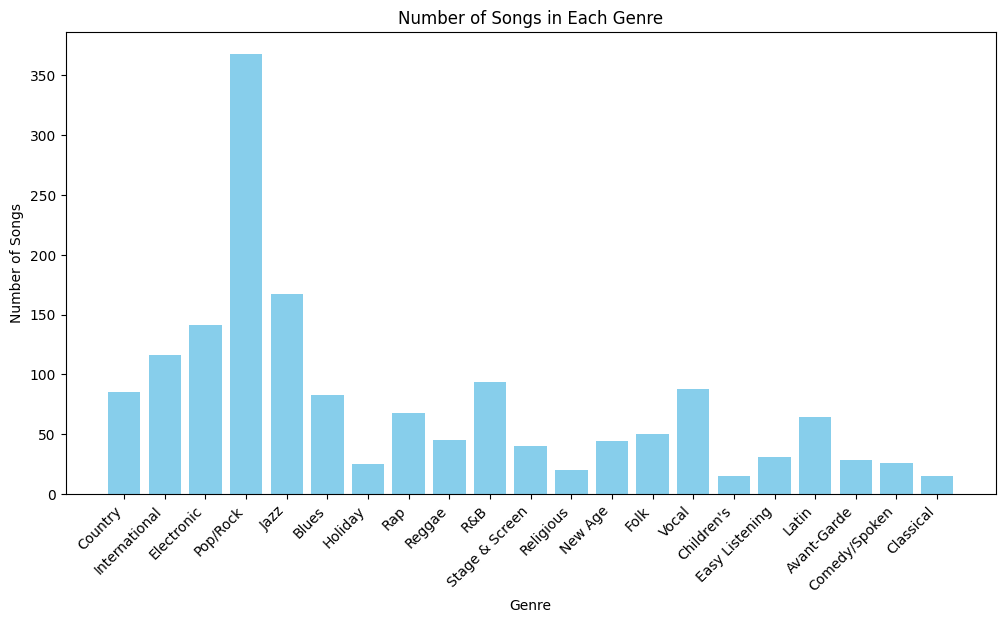

In [3]:

# Split the GenresStr column into a list of genres
metadata_df['GenresList'] = metadata_df['GenresStr'].str.split(';')

# Flatten the list of genres and clean up genre names
all_genres = [genre.strip() for genres_list in metadata_df['GenresList'] for genre in genres_list]

# Count the frequency of each genre
genre_counts = Counter(all_genres)

# Plot the number of genres
plt.figure(figsize=(12, 6))
plt.bar(genre_counts.keys(), genre_counts.values(), color='skyblue')
plt.title('Number of Songs in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

/var/folders/0f/yp6mz4t575v3p73nrx5344040000gn/T/ipykernel_44563/3885586426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_rock_df['MoodsList'] = pop_rock_df['MoodsStr'].str.split(';')


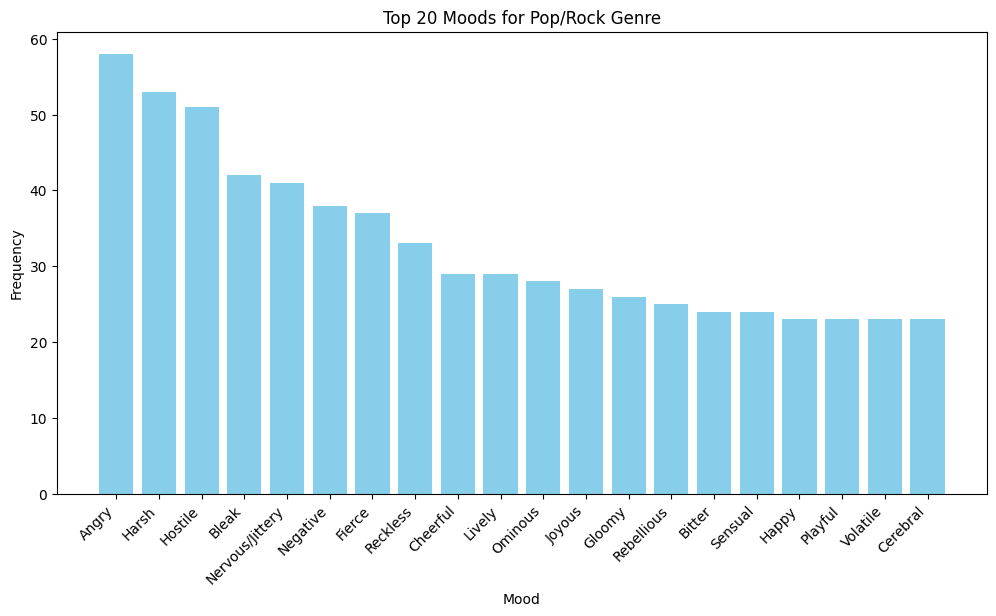

In [4]:
# Filter rows with "Pop/Rock" genre
pop_rock_df = metadata_df[metadata_df['GenresStr'].str.contains('Pop/Rock')]

# Split the MoodsStr column into a list of moods
pop_rock_df['MoodsList'] = pop_rock_df['MoodsStr'].str.split(';')

# Flatten the list of moods
all_moods_pop_rock = [mood.strip() for moods_list in pop_rock_df['MoodsList'] for mood in moods_list]

# Count the frequency of each mood
mood_counts_pop_rock = Counter(all_moods_pop_rock)

# Get the top 20 moods and their frequencies
top_20_moods_pop_rock = mood_counts_pop_rock.most_common(20)

# Extract the moods and frequencies
top_20_moods, top_20_frequencies = zip(*top_20_moods_pop_rock)

# Plot the top 20 moods for Pop/Rock genre
plt.figure(figsize=(12, 6))
plt.bar(top_20_moods, top_20_frequencies, color='skyblue')
plt.title('Top 20 Moods for Pop/Rock Genre')
plt.xlabel('Mood')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()


In [5]:
# Filter Pop/Rock songs
# pop_rock_df = annotations_df[annotations_df['GenresStr'].str.contains('Pop/Rock')]

# Filter songs containing Emotional #tags in the MoodsStr column
emotions_pairs = [('happy', 'sad'),('happy', 'angry'), ('happy', 'gentle'), ('sad', 'gentle'), ('sad', 'angry'), ('gentle','angry')]
emotions = ['happy', 'sad', 'angry', 'gentle']

# Create a dictionary to store DataFrames and counts for each pair of emotions
emotion_data = {}

for emotion in emotions:
    filtered_df = pop_rock_df[pop_rock_df['MoodsStr'].str.contains(emotion, case=False, regex=True)]

    if len(filtered_df) > 0:
        # Extract relevant information and create a new DataFrame
        result_df = pd.DataFrame({
            'Song': filtered_df['Song'],
            'Quadrant': filtered_df['Quadrant'],
            'SingleMood': filtered_df['MoodsStr'].apply(lambda x: emotion)
        })

        # Store the DataFrame and count in the dictionary
        emotion_data[emotion] = result_df
    else:
        print(f"No Pop/Rock songs containing '{emotion}' found.")

emotion_data = pd.concat(emotion_data, ignore_index=True)

In [6]:
# Define the correspondence
correspondence = {"happy": "Q1", "sad":"Q3", "angry":"Q2", "gentle": "Q4"}

# Create a mask that matches the correspondence
mask = emotion_data['SingleMood'].map(correspondence) == emotion_data['Quadrant']

# Filter the DataFrame
emotion_data = emotion_data.loc[mask]
emotion_data.reset_index(drop=True, inplace=True)

In [7]:
counts = emotion_data['SingleMood'].value_counts()
print(counts)

SingleMood
angry     58
gentle    22
happy     21
sad       20
Name: count, dtype: int64


In [8]:
emotion_data_samples = emotion_data.groupby('SingleMood').apply(lambda x: x.sample(n=20, random_state=42)).reset_index(drop=True)

In [9]:
display(emotion_data_samples)

Song Quadrant SingleMood
0   MT0000133200       Q2      angry
1   MT0001975228       Q2      angry
2   MT0010897525       Q2      angry
3   MT0005550288       Q2      angry
4   MT0015541501       Q2      angry
..           ...      ...        ...
75  MT0009385684       Q3        sad
76  MT0005270263       Q3        sad
77  MT0007043936       Q3        sad
78  MT0009628869       Q3        sad
79  MT0005262725       Q3        sad

[80 rows x 3 columns]

In [10]:
counts = emotion_data_samples['SingleMood'].value_counts()
print(counts)

SingleMood
angry     20
gentle    20
happy     20
sad       20
Name: count, dtype: int64


In [11]:
diagonal_pairs = [['happy' , 'sad'], ['gentle', 'angry']]
horizontal_pairs = [['happy', 'angry'], ['sad', 'gentle']]
vertical_pairs = [['happy', 'gentle'], ['angry', 'sad']]

In [12]:
path = "human_dataset/MER_audio_taffc_dataset/"

def calculate_essentia_features_statistics(df):
    essentia_features = []
    # Iterate over the rows of the DataFrame
    for i, row in df.iterrows():
        # Extract the features using Essentia
        features, features_frames = es.MusicExtractor(lowlevelStats=['mean', 'stdev'], rhythmStats=['mean', 'stdev'], tonalStats=['mean', 'stdev'])(path+row['Quadrant']+'/'+row['Song']+ '.mp3')

        essentia_features.append(features)

    return essentia_features

In [13]:
essentia_features_statistics = calculate_essentia_features_statistics(emotion_data_samples)

[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

In [14]:
relevant_features = [
    'lowlevel.pitch_salience.mean', # melody
    'lowlevel.pitch_salience.stdev', # melody

    'tonal.hpcp_entropy.mean', # harmony
    'tonal.hpcp_entropy.stdev', # harmony
    'tonal.chords_number_rate', # harmony
    'tonal.chords_changes_rate', # harmony
    'tonal.key_krumhansl.scale', # harmony

    'lowlevel.average_loudness', # dynamic

    'lowlevel.spectral_centroid.mean', # timbre
    'lowlevel.spectral_centroid.stdev', # timbre
    'lowlevel.spectral_kurtosis.mean', # timbre
    'lowlevel.spectral_kurtosis.stdev', # timbre
    'lowlevel.dissonance.mean', # timbre
    'lowlevel.dissonance.stdev', # timbre

    'rhythm.onset_rate', # rhythm
    'rhythm.bpm', # rhythm
    'rhythm.bpm_histogram' # rhythm
]

categorical_features = ['tonal.key_krumhansl.scale', 'tonal.chords_key']


In [15]:
data_relevant_features = pd.DataFrame([{feature: essentia_features_statistics[i][feature] for feature in relevant_features} for i in range(len(essentia_features_statistics))])

In [16]:
def calculate_tempo_entropy(row):
    bpm_histogram = row['rhythm.bpm_histogram']
    entropy_bpm = stats.entropy(bpm_histogram)
    row['rhythm.bpm_histogram_entropy'] = entropy_bpm
    return row

data_relevant_features = data_relevant_features.apply(calculate_tempo_entropy, axis=1)
data_relevant_features = data_relevant_features.drop('rhythm.bpm_histogram', axis=1)

In [17]:
# Add mood to the DataFrame
data_relevant_features = pd.concat([emotion_data_samples['SingleMood'], data_relevant_features], axis=1)
data_relevant_features.rename(columns={'SingleMood': 'mood'}, inplace=True)

In [18]:
data_relevant_features.to_csv('data_relevant_features_human.csv', index=False)
# data_relevant_features = pd.read_csv('data_relevant_features.csv')

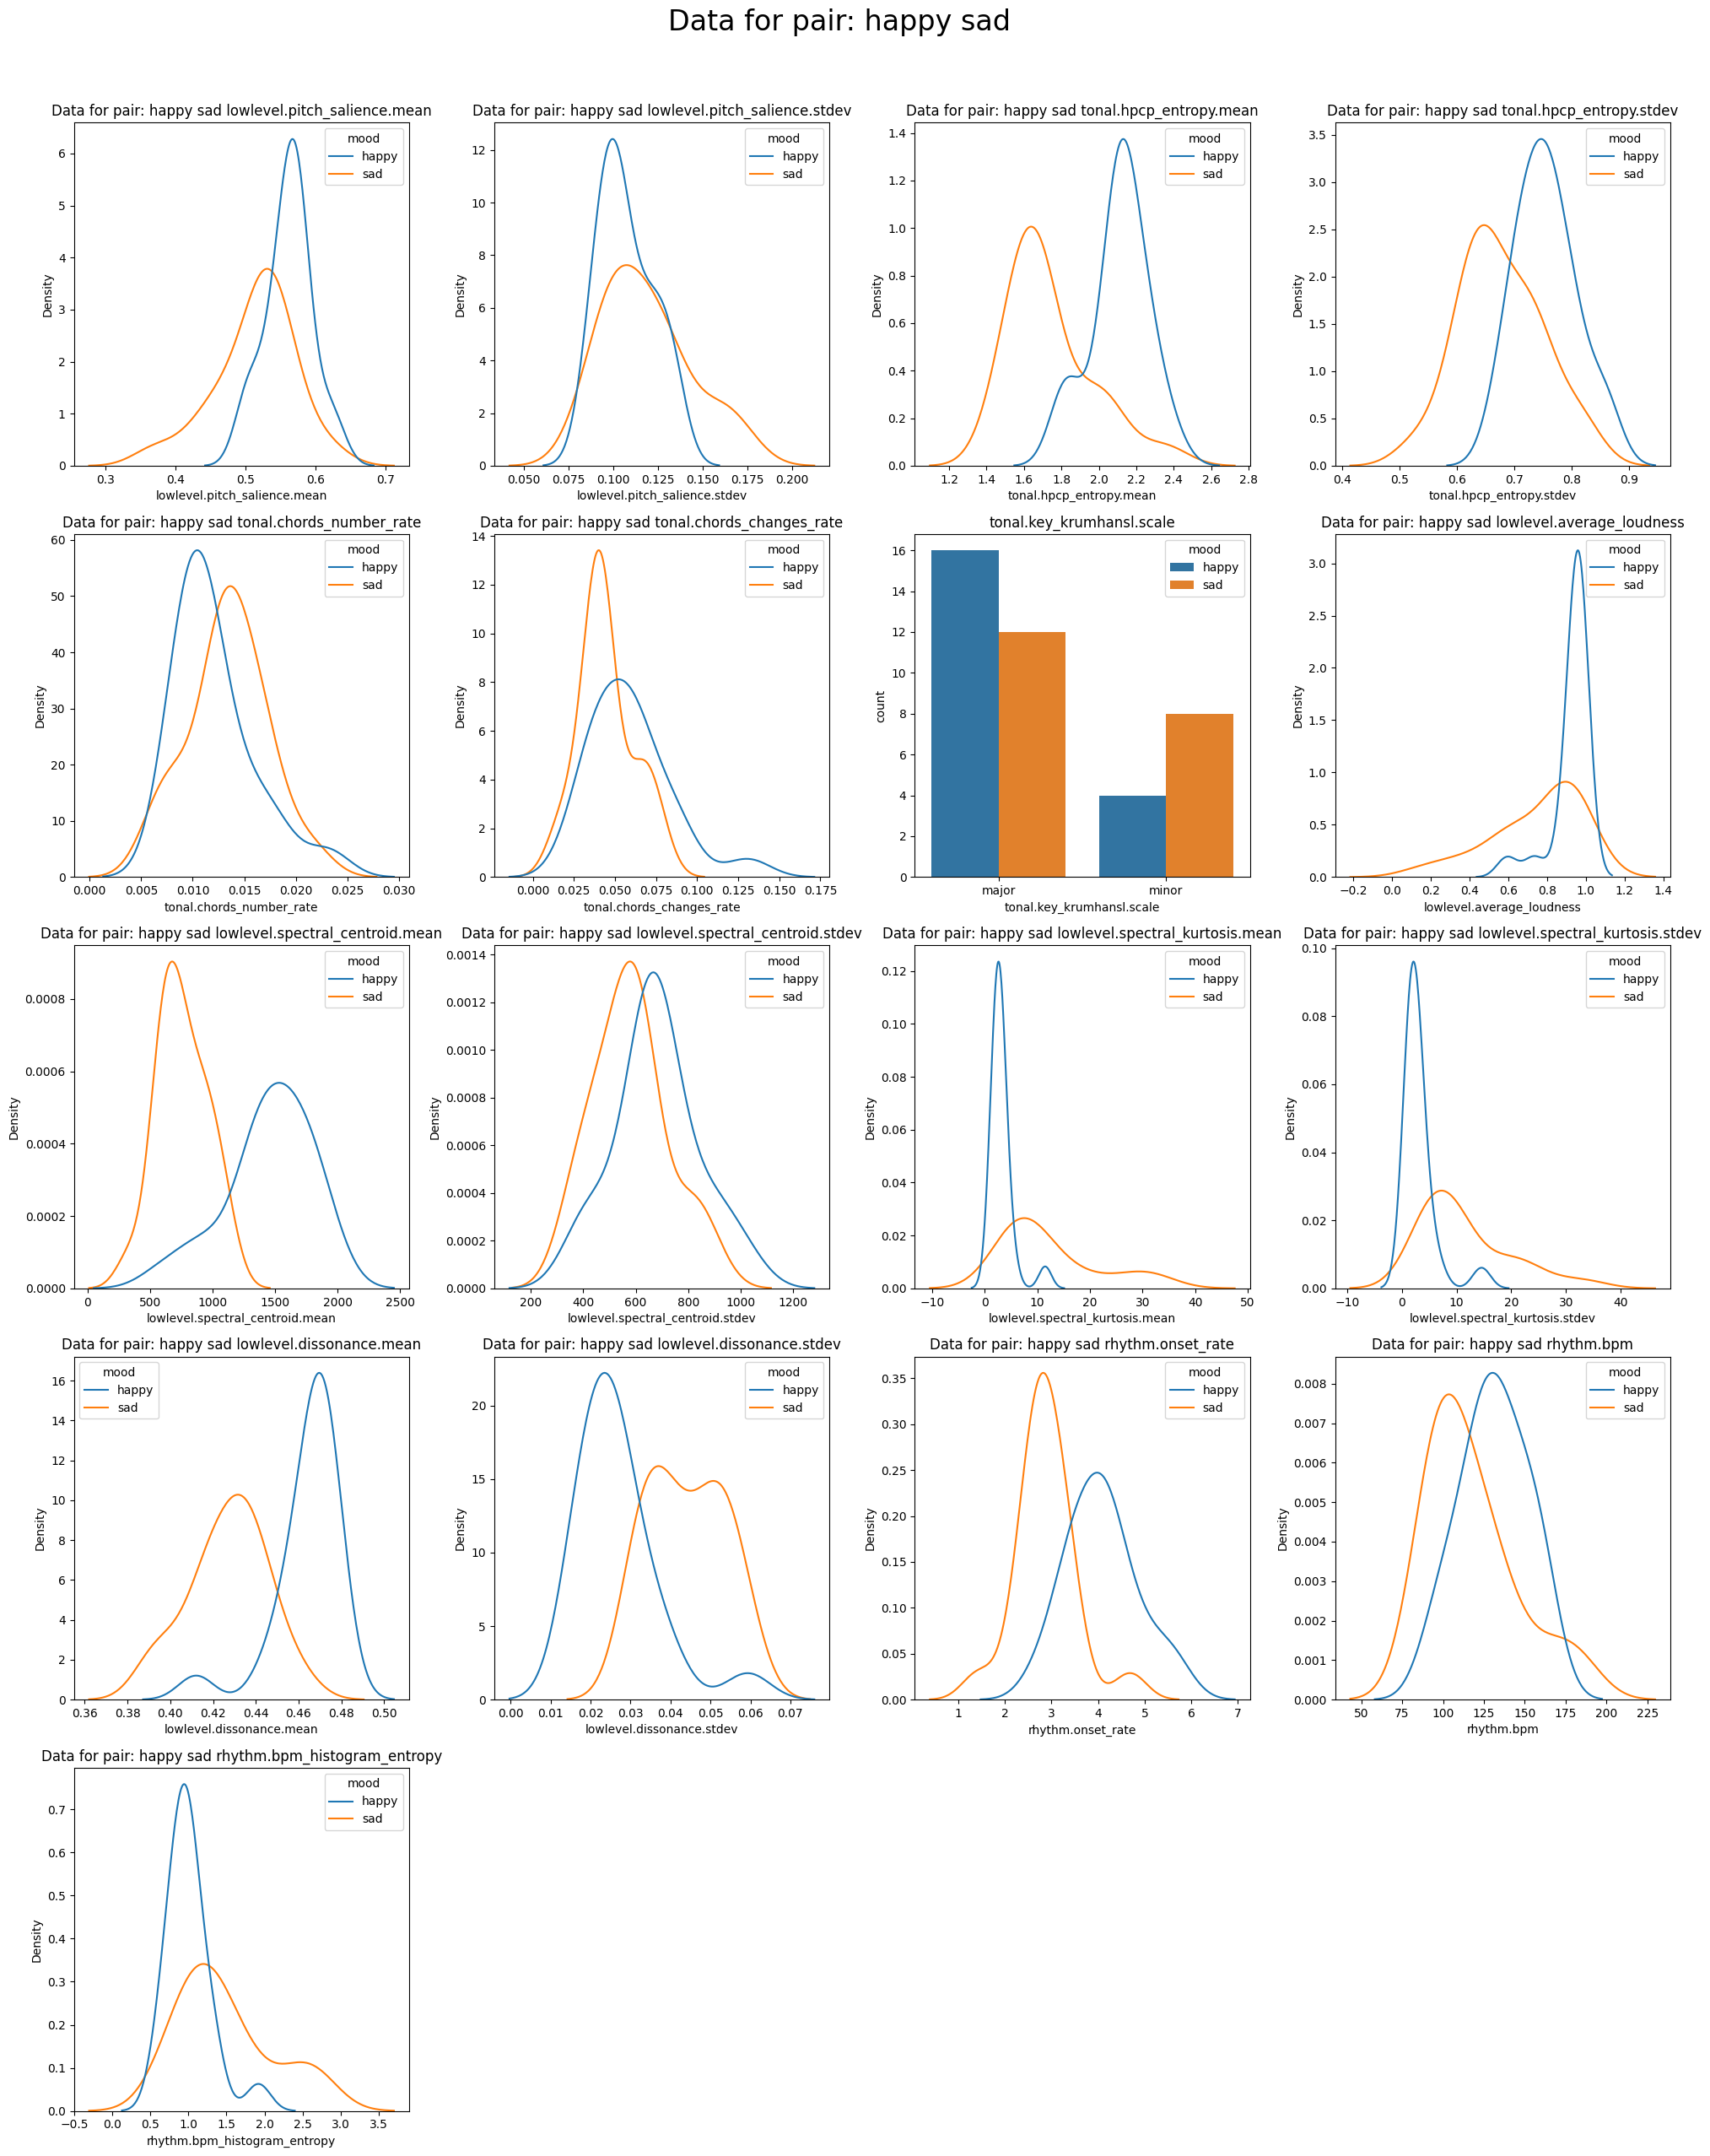

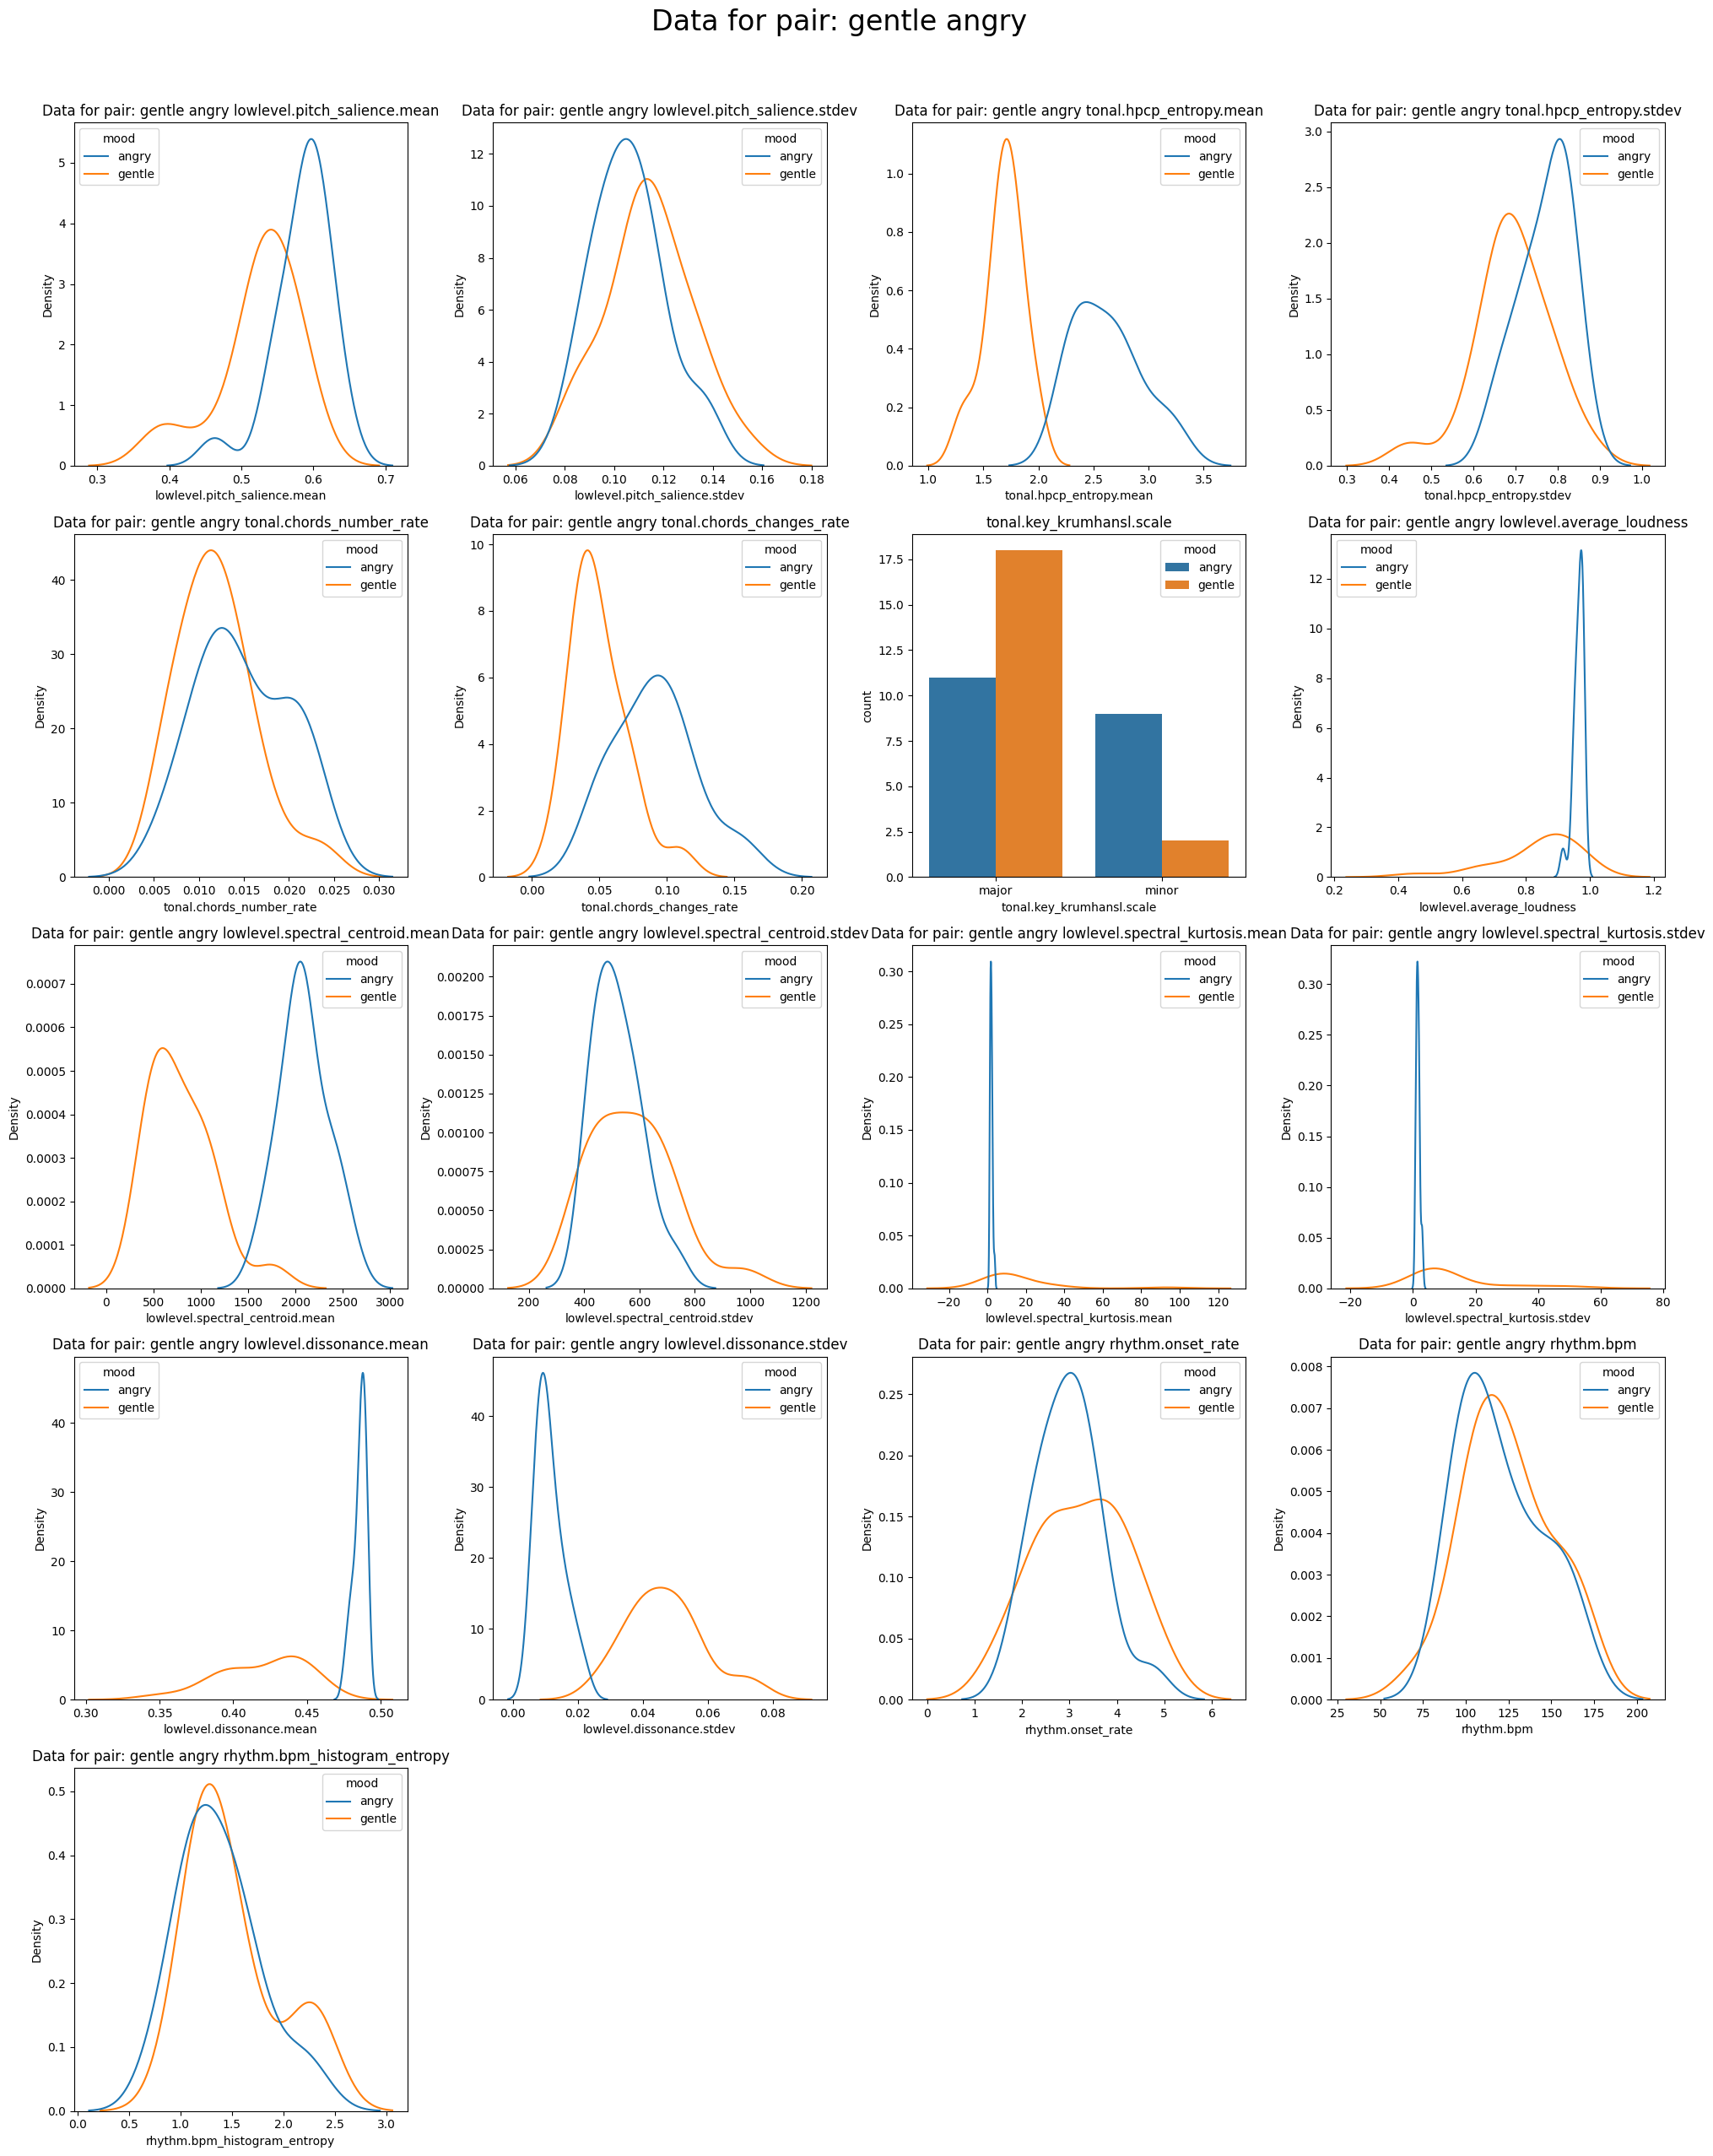

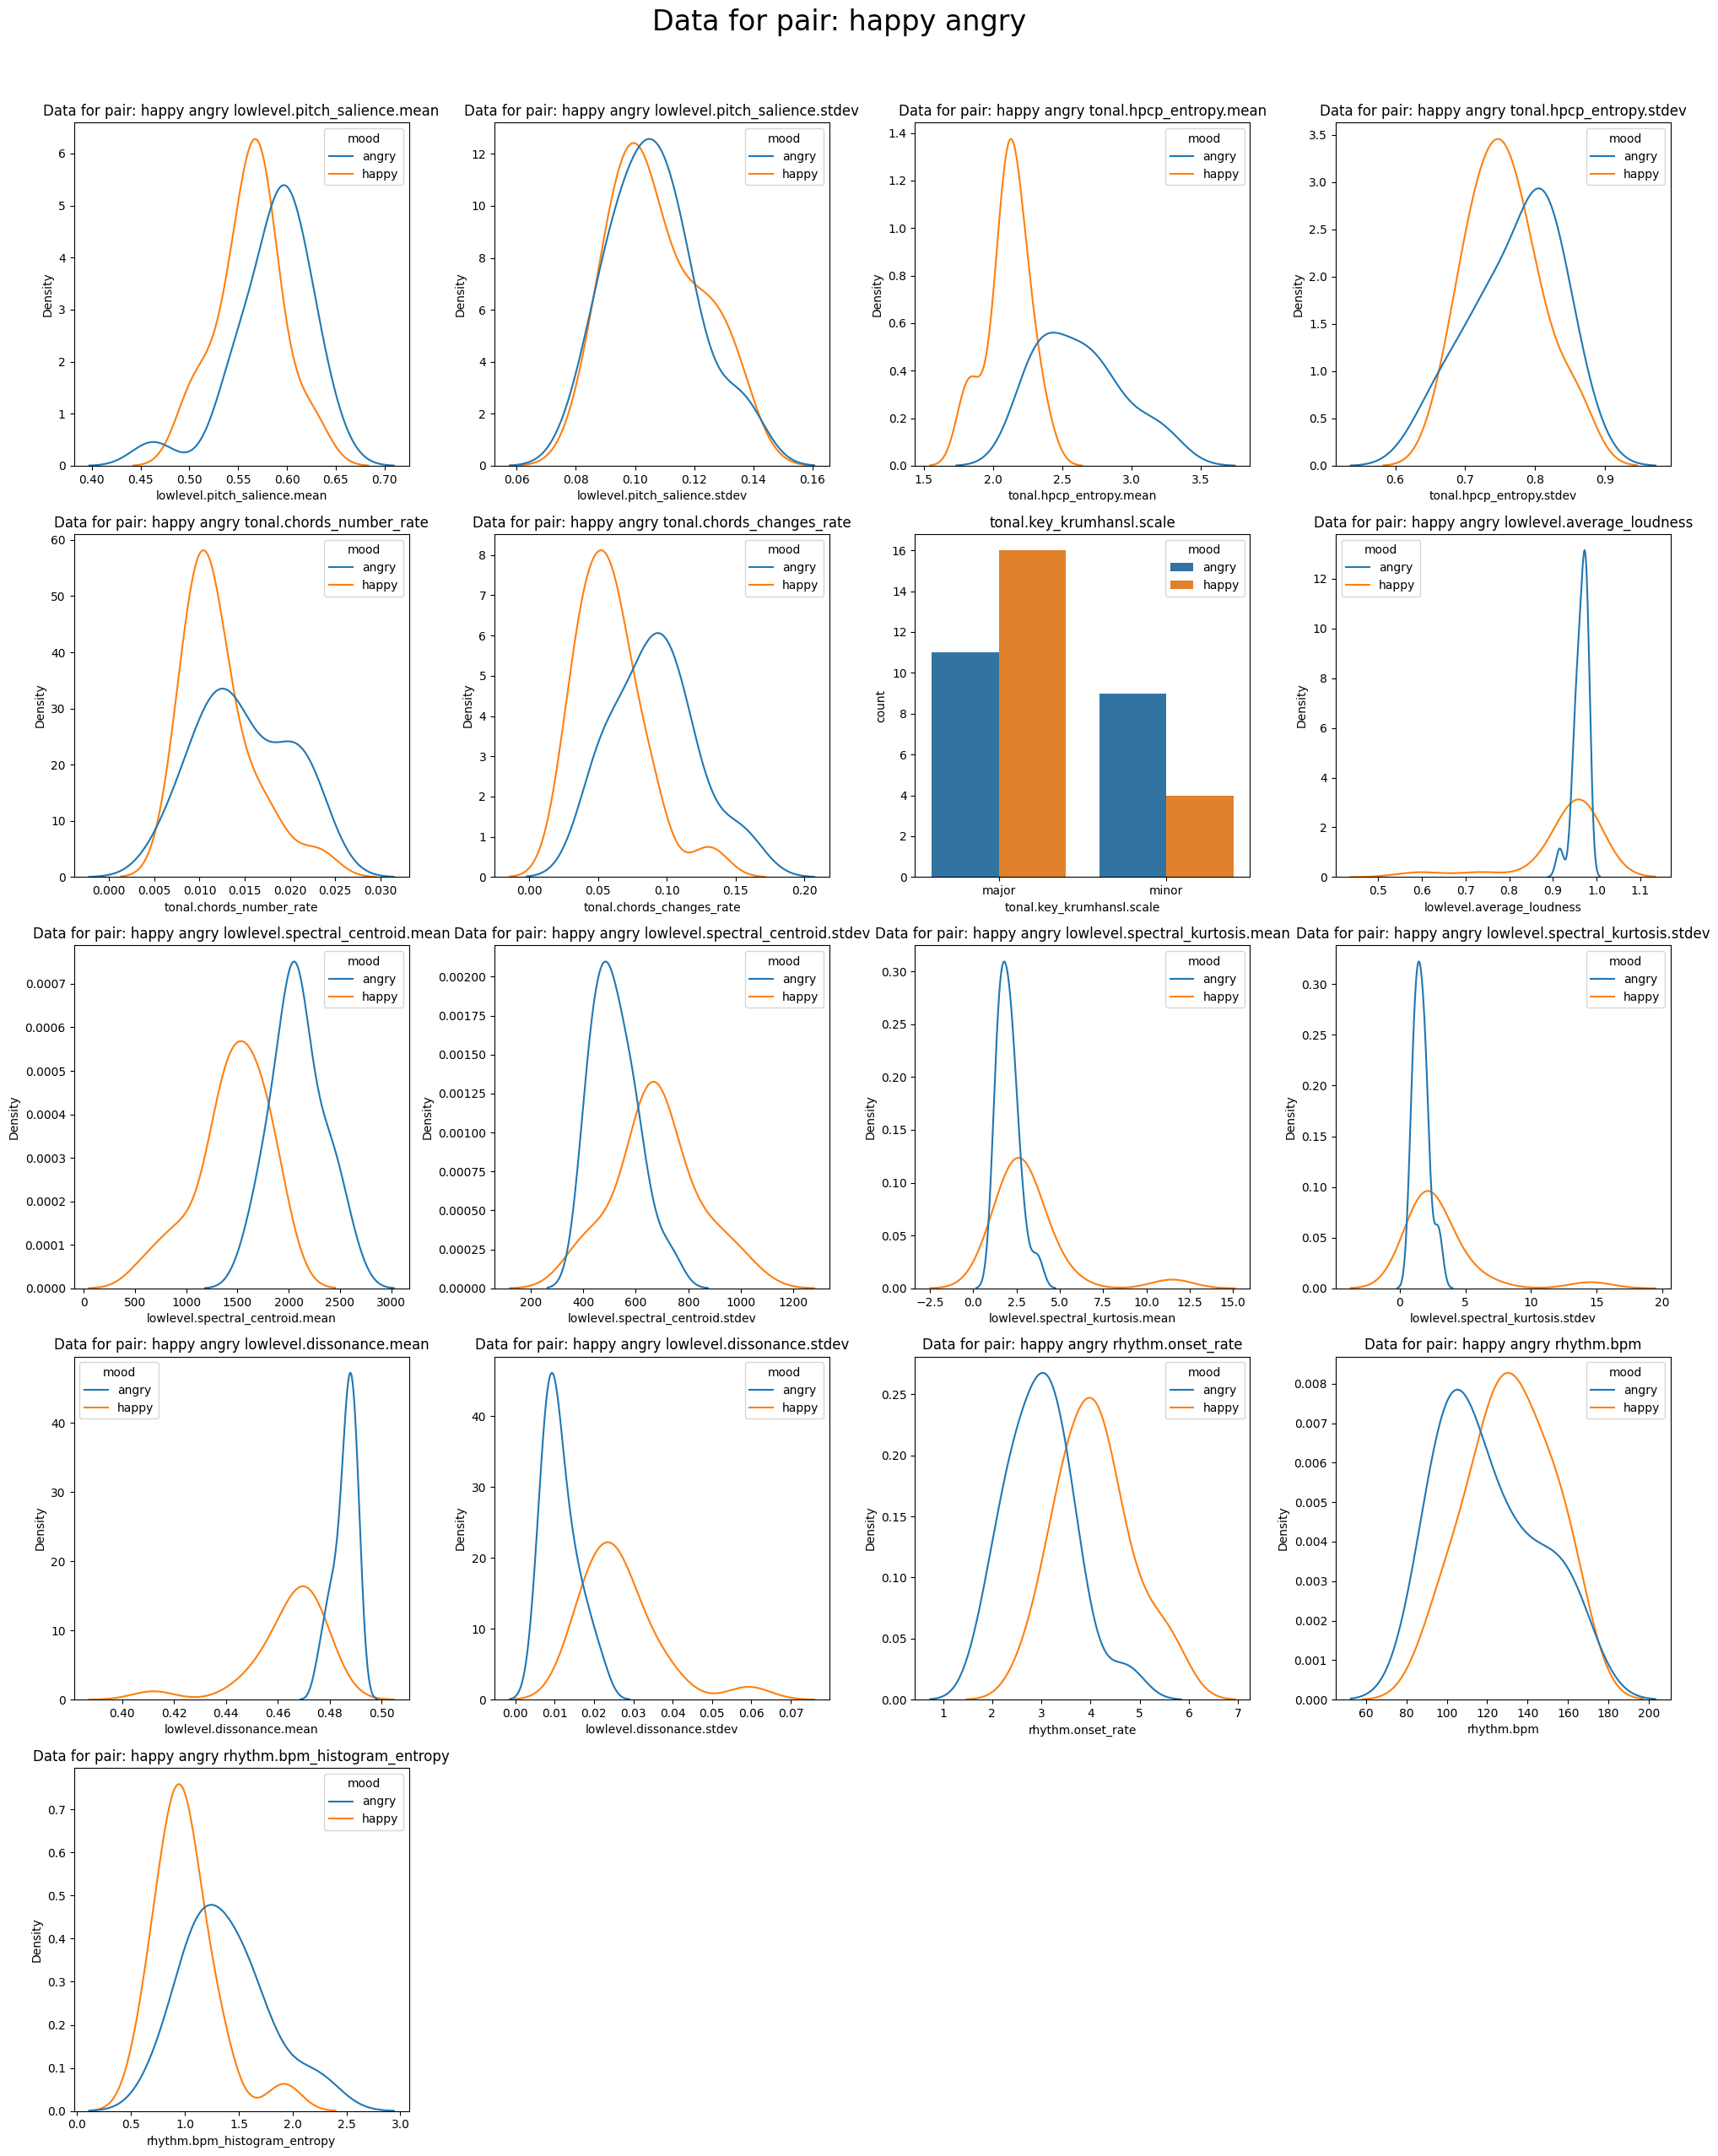

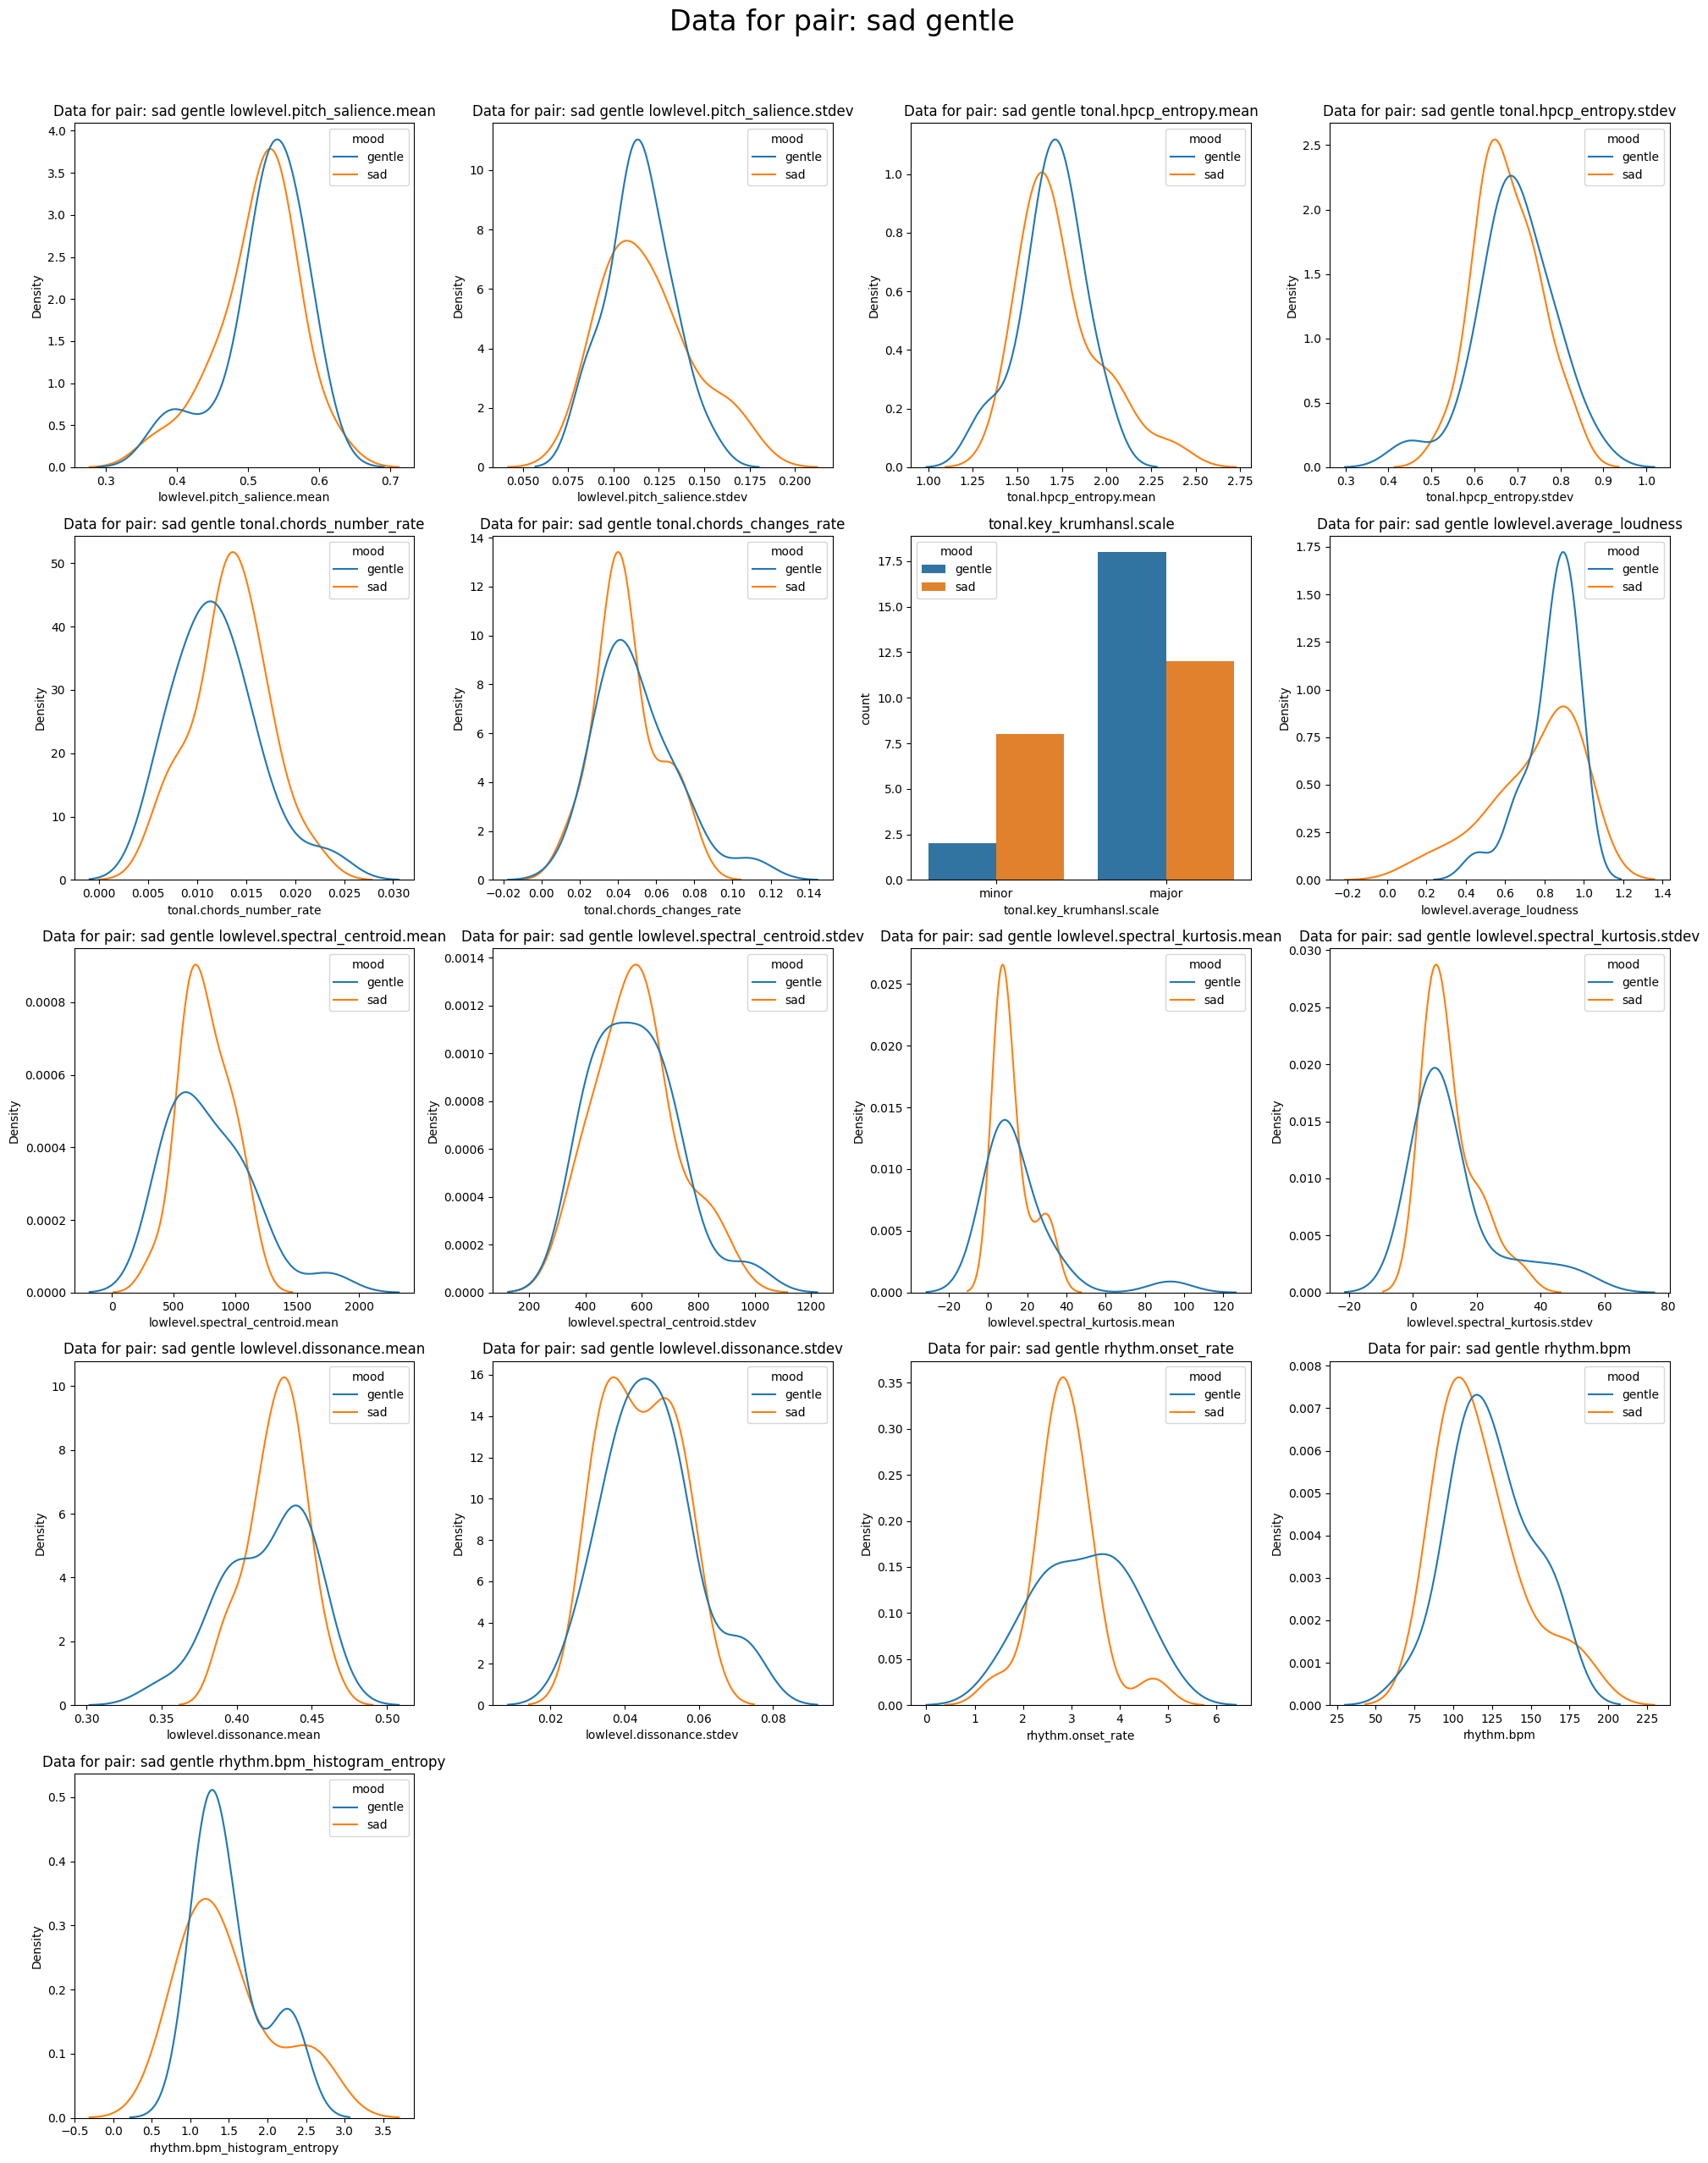

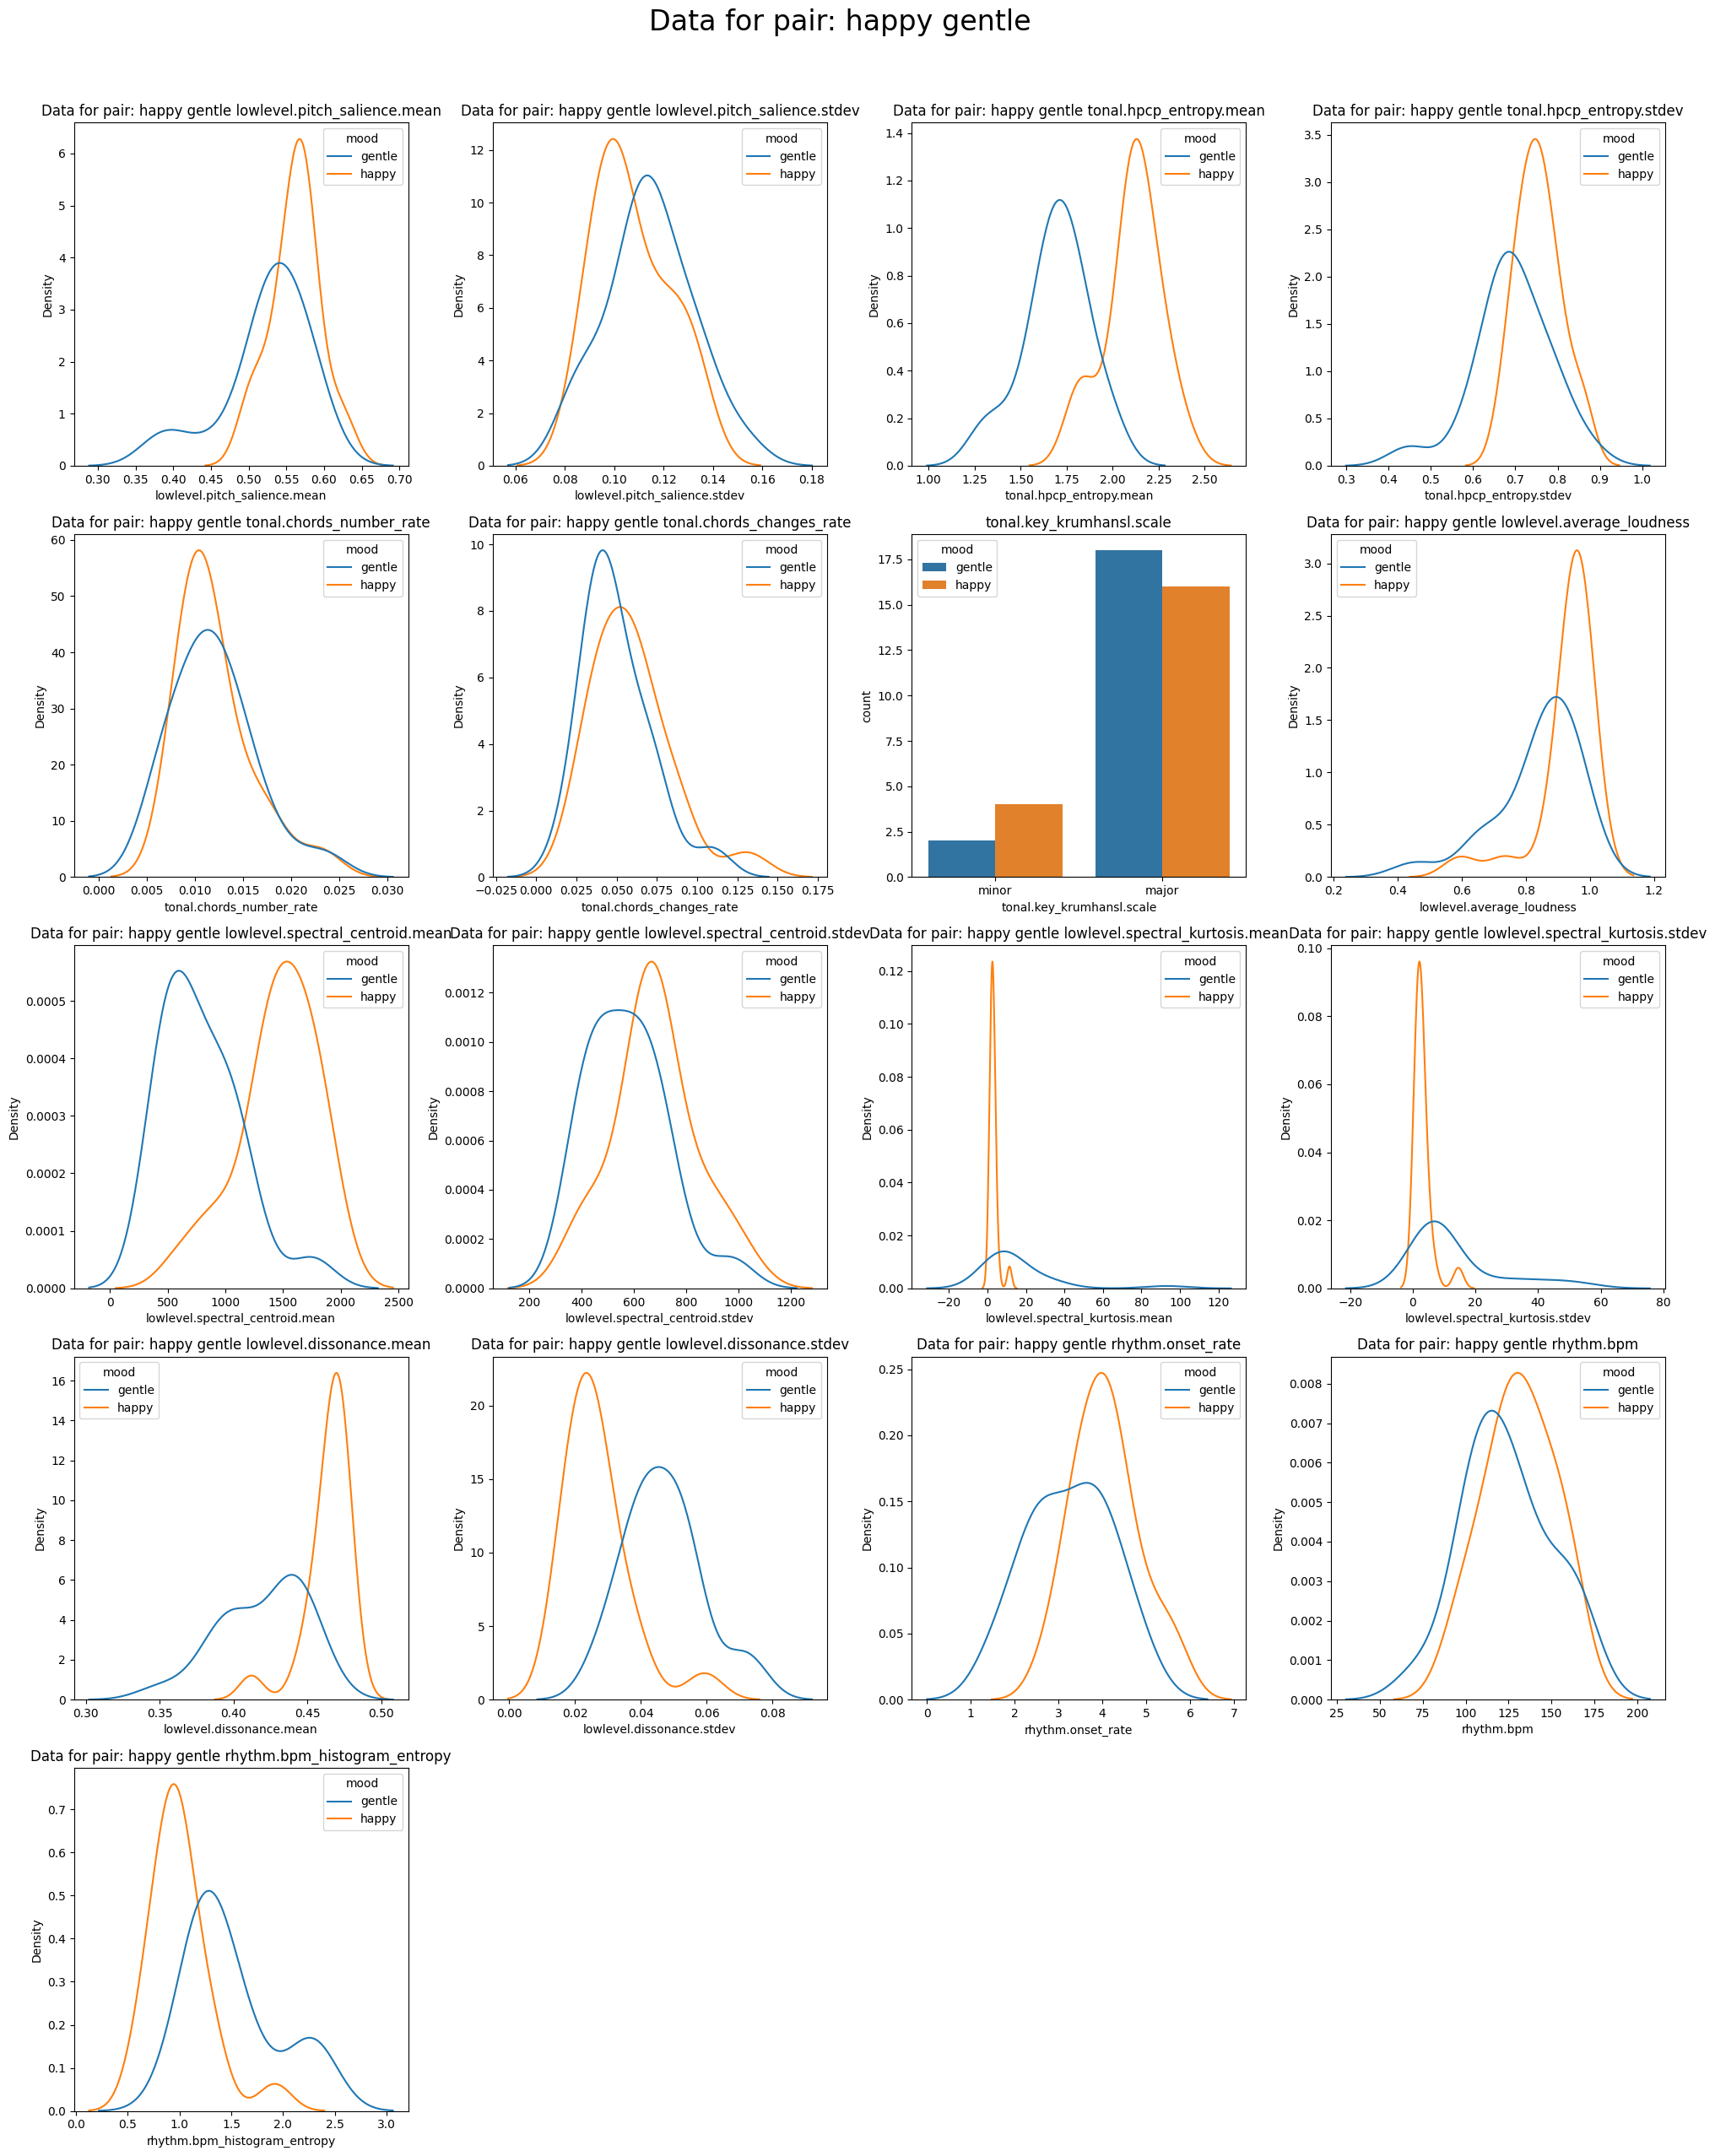

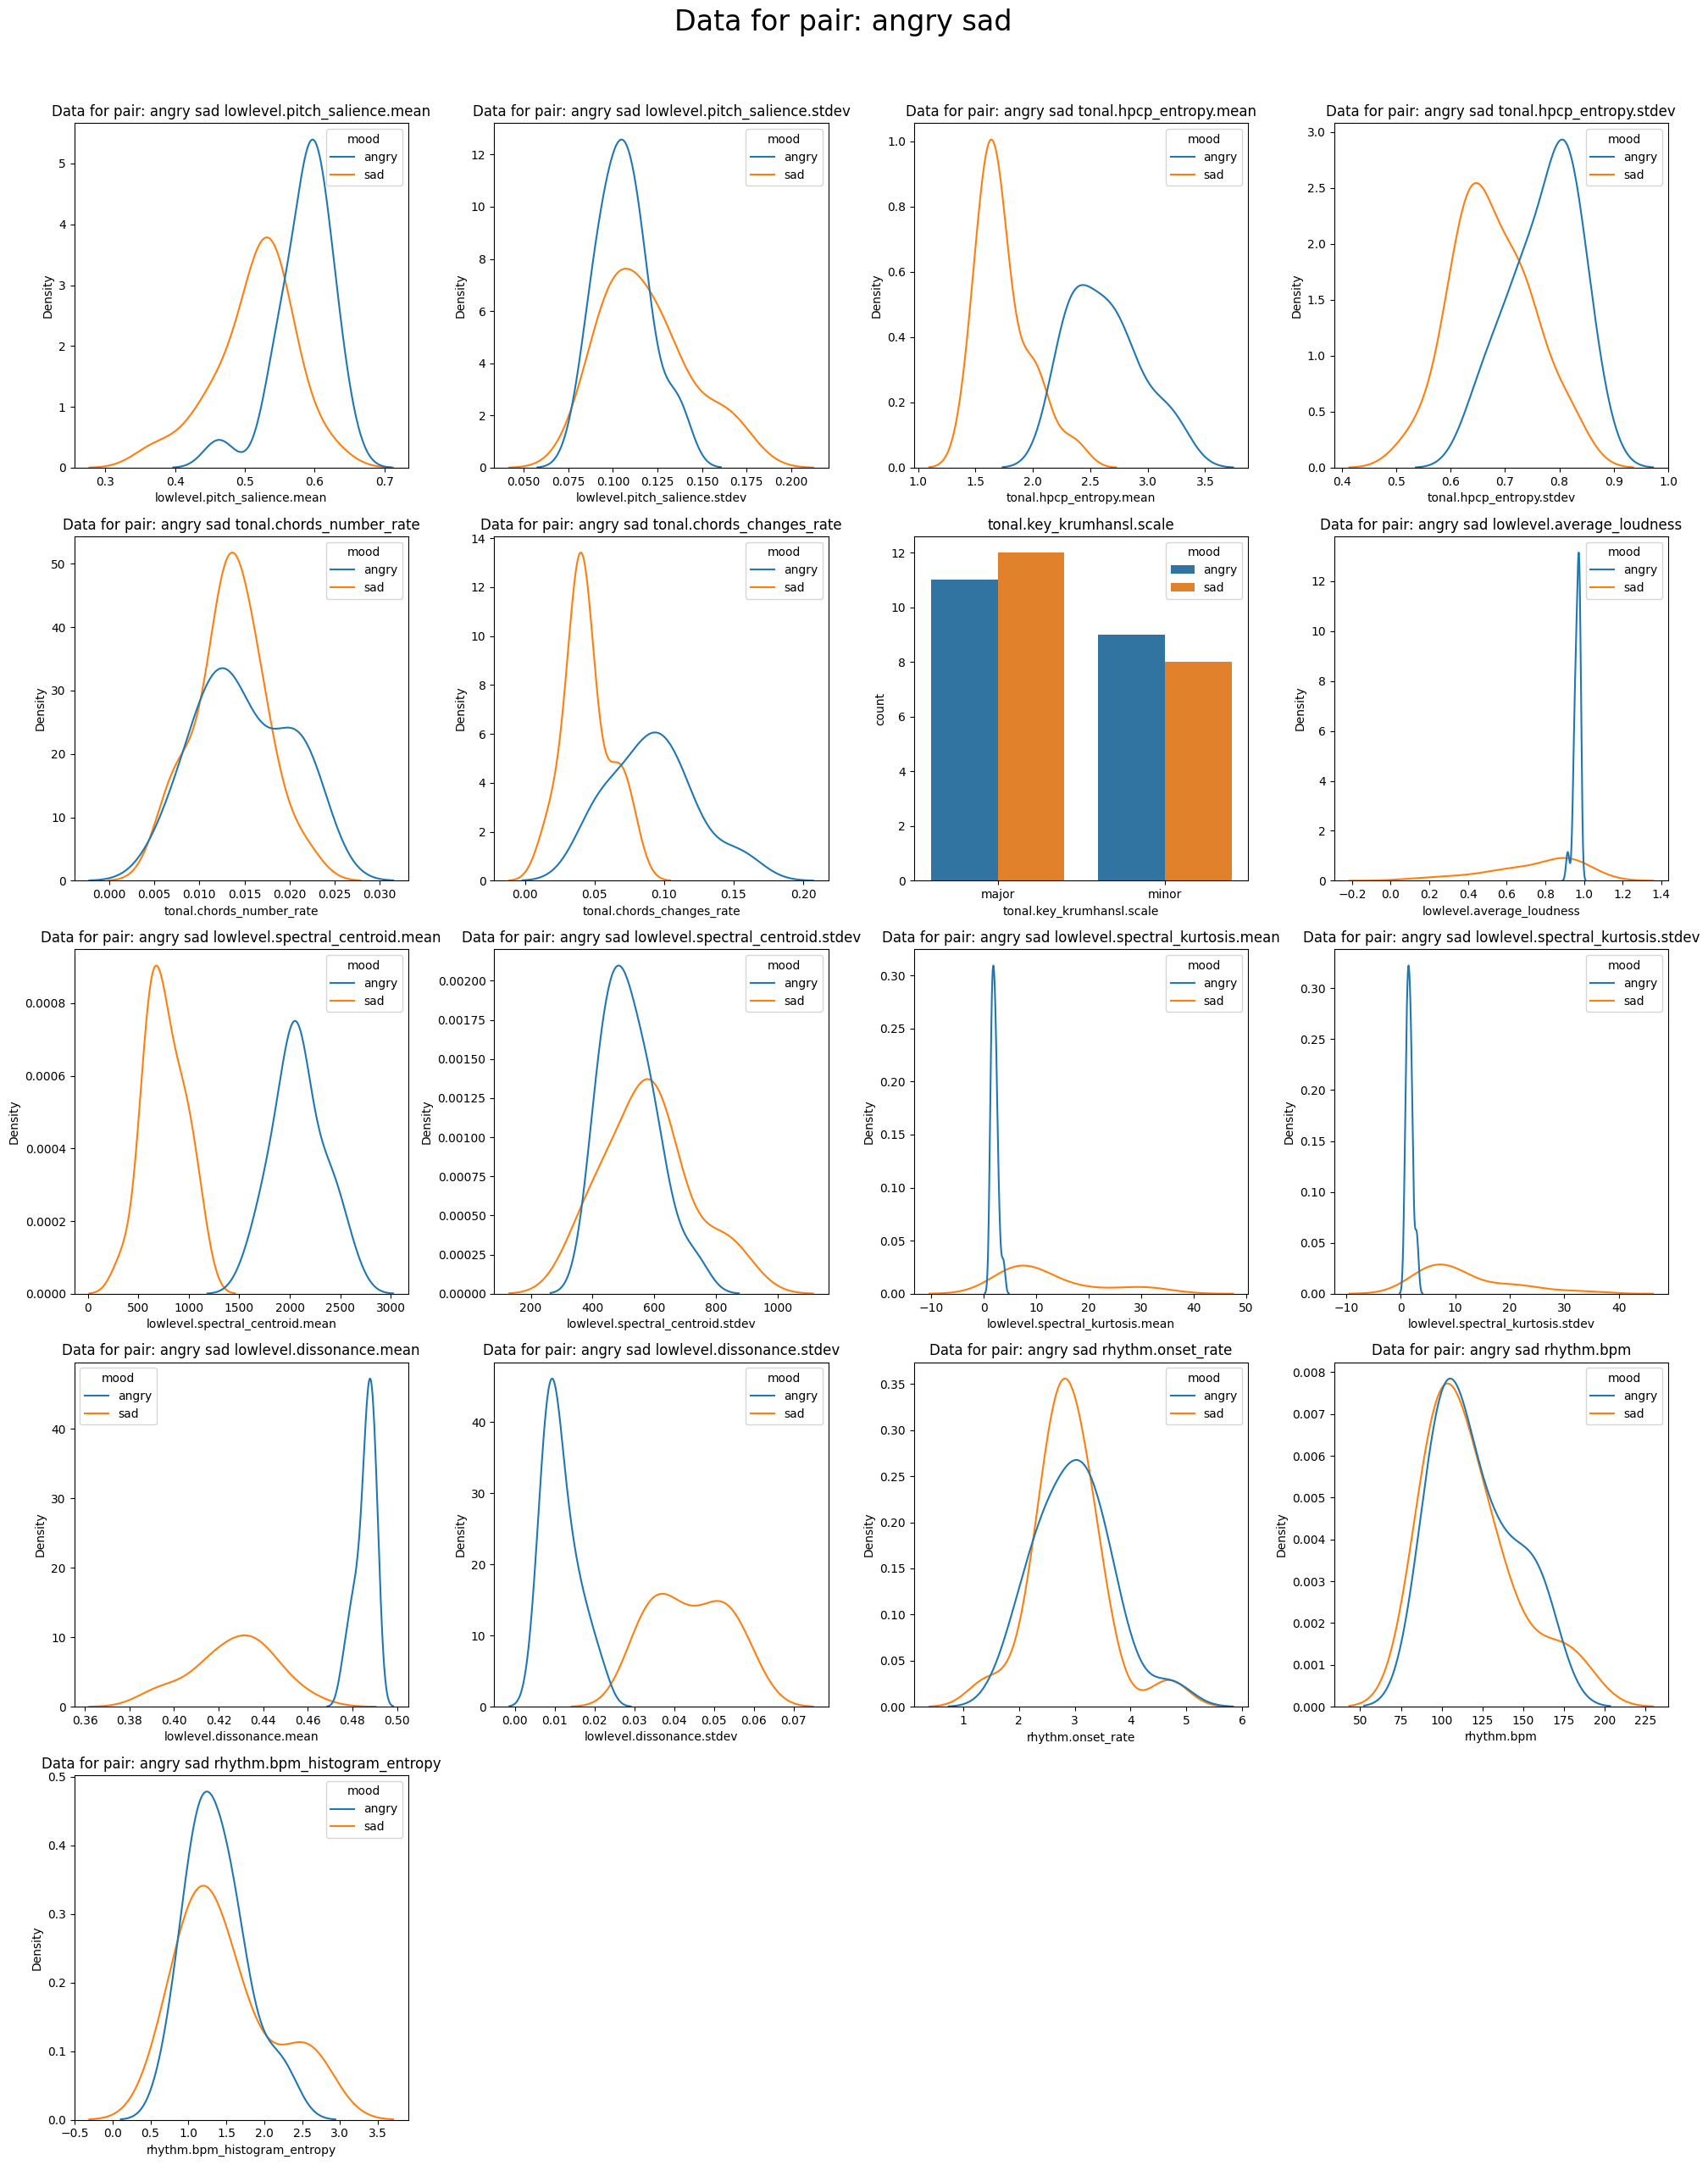

In [19]:
for pairs in [diagonal_pairs, horizontal_pairs, vertical_pairs]:
    
    for pair in pairs:
        df_filtered = data_relevant_features[(data_relevant_features['mood'] == pair[0]) | (data_relevant_features['mood'] == pair[1])]
        
        plot_features = [feature for feature in relevant_features if feature != 'rhythm.bpm_histogram']
        plot_features += ['rhythm.bpm_histogram_entropy']

        num_features = len(plot_features)
        num_cols = 4
        num_rows = math.ceil(num_features / num_cols)

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
        axs = axs.ravel()

        fig.suptitle('Data for pair: {} {}'.format(pair[0], pair[1]), fontsize=24, y=1.02)

        for i, feature in enumerate(plot_features):

            if feature in categorical_features:
                sns.countplot(data=df_filtered, x=feature, hue='mood', ax=axs[i])
                axs[i].set_title(feature)
            elif feature == 'rhythm.bpm_histogram':
                pass
            else:
                sns.kdeplot(data=df_filtered, x=feature, hue='mood', ax=axs[i])
                axs[i].set_title("Data for pair: " + pair[0] + ' ' + pair[1] + ' ' + feature)
        
        for j in range(i + 1, num_rows*num_cols):
            fig.delaxes(axs[j])
        
        plt.tight_layout()
        plt.show()


In [20]:
def calculate_statistics_pairs(data_relevant_features, pairs, features, categorical_features):
    shapiro_results = []
    significance_results = []
    levene_results = []

    for pair in pairs:
        df_moods = data_relevant_features[(data_relevant_features['mood'] == pair[0]) | (data_relevant_features['mood'] == pair[1])]
        df_mood_a = data_relevant_features[(data_relevant_features['mood'] == pair[0])]
        df_mood_b = data_relevant_features[(data_relevant_features['mood'] == pair[1])]
        shapiro_pair_results = []
        significance_pair_results = []
        levene_pair_results = []

        for feature in features:
            if feature != 'rhythm.bpm_histogram':
                data_feature_a = df_mood_a[feature]
                data_feature_b = df_mood_b[feature]

                if feature not in categorical_features:
                    w_statistic_a, p_value_a = stats.shapiro(data_feature_a)
                    is_normal_a = p_value_a > 0.05 

                    w_statistic_b, p_value_b = stats.shapiro(data_feature_b)
                    is_normal_b = p_value_b > 0.05 

                    shapiro_pair_results.append({'Feature': feature, 'Mood A': pair[0], 'W-statistic A': w_statistic_a, 'P-value A': p_value_a, 'Normal Distribution A': is_normal_a, 'Mood B': pair[1], 'W-statistic B': w_statistic_b, 'P-value B': p_value_b, 'Normal Distribution B': is_normal_b})

                    levene_stat, p_value = stats.levene(data_feature_a, data_feature_b)
                    is_equal_variance = p_value > 0.05

                    levene_pair_results.append({'Feature': feature, 'Levene-statistic': levene_stat, 'P-value': p_value, 'Equal Variance': is_equal_variance})

                    if(is_normal_a and is_normal_b):
                        t_statistic, p_value = stats.ttest_ind(data_feature_a, data_feature_b, equal_var=is_equal_variance)
                        is_significant = p_value < 0.05
                        significance_pair_results.append({'Feature': feature, 'Test': ('Student t-test' if is_equal_variance else 'Welch t-Test'), 'Statistic': t_statistic, 'P-value': p_value, 'Significant': is_significant})
                    else:
                        mann_whitney_u_statistic, p_value = stats.mannwhitneyu(data_feature_a, data_feature_b)
                        is_significant = p_value < 0.05
                        significance_pair_results.append({'Feature': feature, 'Test': 'Mann-Whitney U-test', 'Statistic': mann_whitney_u_statistic, 'P-value': p_value, 'Significant': is_significant})
                else:
                    chi2_stat, p_value, dof, ex = stats.chi2_contingency(pd.crosstab(df_moods['mood'], df_moods[feature]))
                    is_significant = p_value < 0.05
                    significance_pair_results.append({'Feature': feature, 'Test': 'Chi-Square Test', 'Statistic': chi2_stat, 'P-value': p_value, 'Significant': is_significant})

        shapiro_results.append(pd.DataFrame(shapiro_pair_results))
        significance_results.append(pd.DataFrame(significance_pair_results))
        levene_results.append(pd.DataFrame(levene_pair_results))

    return significance_results, shapiro_results, levene_results


In [21]:
# feature_names = {
#     'rhythm.bpm': 'Tempo',
#     'lowlevel.spectral_kurtosis.mean': 'Spectral Kurtosis Mean',
#     'lowlevel.spectral_kurtosis.stdev': 'Spectral Kurtosis Std Dev',
#     'tonal.chords_number_rate': 'Chords Number Rate',
#     'tonal.chords_changes_rate': 'Chord Changes Rate',
#     'lowlevel.dissonance.mean': 'Dissonance Mean', 
#     'lowlevel.dissonance.stdev': 'Dissonance Std Dev', 
#     'lowlevel.average_loudness': 'Average Loudness',
#     'lowlevel.pitch_salience.mean': 'Pitch Salience Mean',
#     'lowlevel.pitch_salience.stdev': 'Pitch Salience Std Dev', 
#     'rhythm.onset_rate': 'Onset Rate', 
#     'lowlevel.spectral_centroid.mean': 'Spectral Centroid Mean',
#     'lowlevel.spectral_centroid.stdev': 'Spectral Centroid Std Dev',
#     'tonal.hpcp_entropy.mean': 'HPCP Entropy Mean',
#     'tonal.hpcp_entropy.stdev': 'HPCP Entropy Std Dev',
#     'tonal.key_krumhansl.scale': 'Scale',
#     'tonal.chords_key': 'Key',
#     'rhythm.bpm_histogram_entropy': 'Tempo Histogram Entropy'
# }

feature_names = {
    'rhythm.bpm': 'Tempo',
    'lowlevel.spectral_kurtosis.mean': 'Spec Kurt',
    'lowlevel.spectral_kurtosis.stdev': 'Spec Kurt Std',
    'tonal.chords_number_rate': 'Chords<br>Num Rate',
    'tonal.chords_changes_rate': 'Chords<br>Chg Rate',
    'lowlevel.dissonance.mean': 'Dissonance', 
    'lowlevel.dissonance.stdev': 'Dissonance Std', 
    'lowlevel.average_loudness': 'Avg<br>Loudness',
    'lowlevel.pitch_salience.mean': 'Pitch<br>Sal',
    'lowlevel.pitch_salience.stdev': 'Pitch<br>Sal Std', 
    'rhythm.onset_rate': 'Onset Rate', 
    'lowlevel.spectral_centroid.mean': 'Spec<br>Cent',
    'lowlevel.spectral_centroid.stdev': 'Spec<br>Cent<br>Std',
    'tonal.hpcp_entropy.mean': 'HPCP Ent',
    'tonal.hpcp_entropy.stdev': 'HPCP Ent Std',
    'tonal.key_krumhansl.scale': 'Scale',
    'rhythm.bpm_histogram_entropy': 'Tempo<br>Hist Ent'
}

In [22]:
categorical_features = ['tonal.key_krumhansl.scale', 'tonal.chords_key']
features = [feature for feature in relevant_features if feature != 'rhythm.bpm_histogram']
features.extend(['rhythm.bpm_histogram_entropy'])

diagonal_significance_results, diagonal_shapiro_results, diagonal_levene_results = calculate_statistics_pairs(data_relevant_features, diagonal_pairs, features, categorical_features)
horizontal_significance_results, horizontal_shapiro_results, horizontal_levene_results = calculate_statistics_pairs(data_relevant_features, horizontal_pairs, features, categorical_features)
vertical_significance_results, vertical_shapiro_results, vertical_levene_results = calculate_statistics_pairs(data_relevant_features, vertical_pairs, features, categorical_features)


In [23]:
movements = ['diagonal', 'horizontal', 'vertical']
pairs = [diagonal_pairs, horizontal_pairs, vertical_pairs]

for i, results in enumerate([diagonal_significance_results, horizontal_significance_results, vertical_significance_results]):
    display(Markdown('**Significance results for {} movement**'.format(movements[i])))
    for index, result in enumerate(results):
        display(Markdown('**Significance results for pair: {} {}**'.format(pairs[i][index][0], pairs[i][index][1])))
        display(Markdown('```'))
        display(result)
        display(Markdown('```'))


**Significance results for diagonal movement**

**Significance results for pair: happy sad**

```

Feature                 Test   Statistic  \
0       lowlevel.pitch_salience.mean       Student t-test    3.284236   
1      lowlevel.pitch_salience.stdev       Student t-test   -1.779572   
2            tonal.hpcp_entropy.mean  Mann-Whitney U-test  365.000000   
3           tonal.hpcp_entropy.stdev       Student t-test    3.994656   
4           tonal.chords_number_rate  Mann-Whitney U-test  143.000000   
5          tonal.chords_changes_rate  Mann-Whitney U-test  266.500000   
6          tonal.key_krumhansl.scale      Chi-Square Test    1.071429   
7          lowlevel.average_loudness  Mann-Whitney U-test  326.000000   
8    lowlevel.spectral_centroid.mean       Student t-test    7.860798   
9   lowlevel.spectral_centroid.stdev       Student t-test    2.092709   
10   lowlevel.spectral_kurtosis.mean  Mann-Whitney U-test   18.000000   
11  lowlevel.spectral_kurtosis.stdev  Mann-Whitney U-test   25.000000   
12          lowlevel.dissonance.mean  Mann-Whitney U-test  377.000000   
13         lowlevel.dissonance.stdev  Mann-Whitney U-test   38.000000   
14                 rhythm.onset_rate       Student t-test    5.477033   
15                        rhythm.bpm  Mann-Whitney U-test  278.000000   
16      rhythm.bpm_histogram_entropy  Mann-Whitney U-test   90.000000   

         P-value  Significant  
0   2.201768e-03         True  
1   8.314509e-02        False  
2   8.597445e-06         True  
3   2.869033e-04         True  
4   1.257898e-01        False  
5   7.402167e-02        False  
6   3.006230e-01        False  
7   6.868222e-04         True  
8   1.737322e-09         True  
9   4.310589e-02         True  
10  9.126647e-07         True  
11  2.355659e-06         True  
12  1.802969e-06         True  
13  1.250516e-05         True  
14  2.968383e-06         True  
15  3.604833e-02         True  
16  3.056629e-03         True

```

**Significance results for pair: gentle angry**

```

Feature                 Test   Statistic  \
0       lowlevel.pitch_salience.mean  Mann-Whitney U-test   52.000000   
1      lowlevel.pitch_salience.stdev       Student t-test    1.612848   
2            tonal.hpcp_entropy.mean         Welch t-Test  -11.746267   
3           tonal.hpcp_entropy.stdev       Student t-test   -3.192988   
4           tonal.chords_number_rate       Student t-test   -1.964985   
5          tonal.chords_changes_rate       Student t-test   -5.020283   
6          tonal.key_krumhansl.scale      Chi-Square Test    4.514107   
7          lowlevel.average_loudness  Mann-Whitney U-test   29.000000   
8    lowlevel.spectral_centroid.mean  Mann-Whitney U-test    1.000000   
9   lowlevel.spectral_centroid.stdev         Welch t-Test    1.369135   
10   lowlevel.spectral_kurtosis.mean  Mann-Whitney U-test  392.000000   
11  lowlevel.spectral_kurtosis.stdev  Mann-Whitney U-test  393.000000   
12          lowlevel.dissonance.mean         Welch t-Test  -10.022298   
13         lowlevel.dissonance.stdev         Welch t-Test   12.683856   
14                 rhythm.onset_rate       Student t-test    1.017595   
15                        rhythm.bpm  Mann-Whitney U-test  231.000000   
16      rhythm.bpm_histogram_entropy  Mann-Whitney U-test  235.000000   

         P-value  Significant  
0   6.610446e-05         True  
1   1.150529e-01        False  
2   8.105552e-13         True  
3   2.827033e-03         True  
4   5.675781e-02        False  
5   1.246116e-05         True  
6   3.361644e-02         True  
7   3.987359e-06         True  
8   7.898034e-08         True  
9   1.810453e-01        False  
10  2.217764e-07         True  
11  1.917712e-07         True  
12  3.353769e-09         True  
13  3.617111e-12         True  
14  3.153060e-01        False  
15  4.093559e-01        False  
16  3.507022e-01        False

```

**Significance results for horizontal movement**

**Significance results for pair: happy angry**

```

Feature                 Test   Statistic  \
0       lowlevel.pitch_salience.mean  Mann-Whitney U-test  110.000000   
1      lowlevel.pitch_salience.stdev       Student t-test    0.250238   
2            tonal.hpcp_entropy.mean         Welch t-Test   -6.723466   
3           tonal.hpcp_entropy.stdev       Student t-test   -0.857885   
4           tonal.chords_number_rate  Mann-Whitney U-test  128.000000   
5          tonal.chords_changes_rate  Mann-Whitney U-test   77.000000   
6          tonal.key_krumhansl.scale      Chi-Square Test    1.823362   
7          lowlevel.average_loudness  Mann-Whitney U-test  137.000000   
8    lowlevel.spectral_centroid.mean       Student t-test   -6.724697   
9   lowlevel.spectral_centroid.stdev       Student t-test    3.948912   
10   lowlevel.spectral_kurtosis.mean  Mann-Whitney U-test  303.000000   
11  lowlevel.spectral_kurtosis.stdev  Mann-Whitney U-test  305.000000   
12          lowlevel.dissonance.mean  Mann-Whitney U-test    4.000000   
13         lowlevel.dissonance.stdev  Mann-Whitney U-test  386.000000   
14                 rhythm.onset_rate       Student t-test    4.841334   
15                        rhythm.bpm  Mann-Whitney U-test  255.000000   
16      rhythm.bpm_histogram_entropy  Mann-Whitney U-test   79.000000   

         P-value  Significant  
0   1.547860e-02         True  
1   8.037514e-01        False  
2   2.809249e-07         True  
3   3.963350e-01        False  
4   5.273532e-02        False  
5   9.198901e-04         True  
6   1.769136e-01        False  
7   9.090738e-02        False  
8   5.812136e-08         True  
9   3.285104e-04         True  
10  5.560460e-03         True  
11  4.702533e-03         True  
12  1.234635e-07         True  
13  5.226885e-07         True  
14  2.176689e-05         True  
15  1.404197e-01        False  
16  1.115947e-03         True

```

**Significance results for pair: sad gentle**

```

Feature                 Test   Statistic  \
0       lowlevel.pitch_salience.mean  Mann-Whitney U-test  174.000000   
1      lowlevel.pitch_salience.stdev       Student t-test    0.661664   
2            tonal.hpcp_entropy.mean  Mann-Whitney U-test  201.000000   
3           tonal.hpcp_entropy.stdev       Student t-test   -0.619014   
4           tonal.chords_number_rate       Student t-test    1.098220   
5          tonal.chords_changes_rate       Student t-test   -0.882643   
6          tonal.key_krumhansl.scale      Chi-Square Test    3.333333   
7          lowlevel.average_loudness  Mann-Whitney U-test  167.000000   
8    lowlevel.spectral_centroid.mean  Mann-Whitney U-test  208.000000   
9   lowlevel.spectral_centroid.stdev       Student t-test    0.145906   
10   lowlevel.spectral_kurtosis.mean  Mann-Whitney U-test  194.000000   
11  lowlevel.spectral_kurtosis.stdev  Mann-Whitney U-test  209.000000   
12          lowlevel.dissonance.mean       Student t-test    0.960973   
13         lowlevel.dissonance.stdev       Student t-test   -0.856715   
14                 rhythm.onset_rate         Welch t-Test   -1.451507   
15                        rhythm.bpm  Mann-Whitney U-test  158.000000   
16      rhythm.bpm_histogram_entropy  Mann-Whitney U-test  177.000000   

     P-value  Significant  
0   0.490334        False  
1   0.512179        False  
2   0.989209        False  
3   0.539601        False  
4   0.279019        False  
5   0.382979        False  
6   0.067889        False  
7   0.379332        False  
8   0.839232        False  
9   0.884767        False  
10  0.881731        False  
11  0.818149        False  
12  0.342641        False  
13  0.396973        False  
14  0.156107        False  
15  0.261616        False  
16  0.542772        False

```

**Significance results for vertical movement**

**Significance results for pair: happy gentle**

```

Feature                 Test   Statistic  \
0       lowlevel.pitch_salience.mean  Mann-Whitney U-test  284.000000   
1      lowlevel.pitch_salience.stdev       Student t-test   -1.369236   
2            tonal.hpcp_entropy.mean       Student t-test    7.988310   
3           tonal.hpcp_entropy.stdev       Student t-test    2.701301   
4           tonal.chords_number_rate  Mann-Whitney U-test  197.000000   
5          tonal.chords_changes_rate  Mann-Whitney U-test  245.500000   
6          tonal.key_krumhansl.scale      Chi-Square Test    0.196078   
7          lowlevel.average_loudness  Mann-Whitney U-test  323.000000   
8    lowlevel.spectral_centroid.mean  Mann-Whitney U-test  361.000000   
9   lowlevel.spectral_centroid.stdev       Student t-test    2.168516   
10   lowlevel.spectral_kurtosis.mean  Mann-Whitney U-test   32.000000   
11  lowlevel.spectral_kurtosis.stdev  Mann-Whitney U-test   39.000000   
12          lowlevel.dissonance.mean  Mann-Whitney U-test  380.000000   
13         lowlevel.dissonance.stdev  Mann-Whitney U-test   31.000000   
14                 rhythm.onset_rate       Student t-test    3.061286   
15                        rhythm.bpm       Student t-test    0.987882   
16      rhythm.bpm_histogram_entropy  Mann-Whitney U-test   51.000000   

         P-value  Significant  
0   2.390315e-02         True  
1   1.789645e-01        False  
2   1.180333e-09         True  
3   1.026141e-02         True  
4   9.459649e-01        False  
5   2.234424e-01        False  
6   6.579050e-01        False  
7   9.209134e-04         True  
8   1.414880e-05         True  
9   3.644637e-02         True  
10  5.873574e-06         True  
11  1.414880e-05         True  
12  1.200888e-06         True  
13  5.165779e-06         True  
14  4.032699e-03         True  
15  3.294591e-01        False  
16  5.895917e-05         True

```

**Significance results for pair: angry sad**

```

Feature                 Test   Statistic  \
0       lowlevel.pitch_salience.mean  Mann-Whitney U-test  348.000000   
1      lowlevel.pitch_salience.stdev         Welch t-Test   -1.972652   
2            tonal.hpcp_entropy.mean  Mann-Whitney U-test  395.000000   
3           tonal.hpcp_entropy.stdev       Student t-test    4.443914   
4           tonal.chords_number_rate       Student t-test    1.073295   
5          tonal.chords_changes_rate         Welch t-Test    6.088268   
6          tonal.key_krumhansl.scale      Chi-Square Test    0.000000   
7          lowlevel.average_loudness  Mann-Whitney U-test  365.000000   
8    lowlevel.spectral_centroid.mean       Student t-test   18.438748   
9   lowlevel.spectral_centroid.stdev       Student t-test   -1.619443   
10   lowlevel.spectral_kurtosis.mean  Mann-Whitney U-test    0.000000   
11  lowlevel.spectral_kurtosis.stdev  Mann-Whitney U-test    0.000000   
12          lowlevel.dissonance.mean         Welch t-Test   14.207575   
13         lowlevel.dissonance.stdev         Welch t-Test  -13.907342   
14                 rhythm.onset_rate       Student t-test    0.504766   
15                        rhythm.bpm  Mann-Whitney U-test  223.000000   
16      rhythm.bpm_histogram_entropy  Mann-Whitney U-test  192.000000   

         P-value  Significant  
0   6.610446e-05         True  
1   5.755816e-02        False  
2   1.430853e-07         True  
3   7.411581e-05         True  
4   2.899076e-01        False  
5   1.236085e-06         True  
6   1.000000e+00        False  
7   8.597445e-06         True  
8   1.495586e-20         True  
9   1.136228e-01        False  
10  6.795615e-08         True  
11  6.795615e-08         True  
12  2.777834e-12         True  
13  1.018545e-13         True  
14  6.166383e-01        False  
15  5.427717e-01        False  
16  8.392322e-01        False

```

In [24]:
from plotly.subplots import make_subplots

color_index = 0
# Create a subplot with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3, subplot_titles=("Diagonal", "Horizontal", "Vertical"), specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]])

pairs_list = [diagonal_pairs, horizontal_pairs, vertical_pairs]
results_list = [diagonal_significance_results, horizontal_significance_results, vertical_significance_results]
threshold = 0.95

for col, (pairs, results) in enumerate(zip(pairs_list, results_list), start=1):
    plot_data = []
    for index in range(len(pairs)):
        categories = results[0]['Feature']
        categories = [*categories, categories[0]]
        values = 1 - results[index]['P-value']
        values = [*values, values[0]]
        plot_data.append(go.Scatterpolar(r=values, theta=[feature_names.get(feature, feature) for feature in categories], name='{} {}'.format(pairs[index][0], pairs[index][1]), subplot='polar{}'.format(col)))
    plot_data.append(go.Scatterpolar(r=[threshold]*len(categories), theta=[feature_names.get(feature, feature) for feature in categories], name='Threshold', line=dict(color='black', dash='dash'), subplot='polar{}'.format(col)))
    for trace in plot_data:
        fig.add_trace(trace)

fig.update_layout(
    autosize=False,
    width=2700,
    height=1000,
    showlegend=True,
    polar=dict(
        radialaxis=dict(visible=True),
    ),
    polar2=dict(
        radialaxis=dict(visible=True),
    ),
    polar3=dict(
        radialaxis=dict(visible=True),
    )
)

fig.show()



In [25]:
import itertools

colors = ['blue', 'orange', 'green', 'red', 'gold', 'purple'] 
colors = ["#e60049", "#0bb4ff", "#50e991", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]
color_cycle = itertools.cycle(colors)

In [26]:
categories = diagonal_significance_results[0]['Feature']
categories = [*categories, categories[0]]

plot_data = []
for index in range(len(diagonal_pairs)):
    # diagonal_significance_results[index].to_csv('diagonal_significance_results_{}_{}_human.csv'.format(diagonal_pairs[index][0], diagonal_pairs[index][1]), index=False)
    values = 1 - diagonal_significance_results[index]['P-value']
    values = [*values, values[0]]
    # Use the new feature names for the theta parameter
    plot_data.append(go.Scatterpolar(r=values, theta=[feature_names.get(feature, feature) for feature in categories], name='{}-{}'.format(diagonal_pairs[index][0], diagonal_pairs[index][1]), line=dict(color=next(color_cycle), width=5)))
# Add a line to indicate the threshold
threshold = 0.95
# Use the new feature names for the theta parameter
plot_data.append(go.Scatterpolar(r=[threshold]*len(categories), theta=[feature_names.get(feature, feature) for feature in categories], name='Threshold', line=dict(color='black', dash='dash')))

fig = go.Figure(
    data=plot_data,
    layout=go.Layout(
        # title=go.layout.Title(text='Diagonal movement (different Arousal and Valence)'),
        polar={'radialaxis': {'visible': True, 'tickfont': dict(size=18)},
               'angularaxis': {'tickfont': dict(size=35)}
               },
        showlegend=True,
        legend=dict(font=dict(size=35))
    )
)
fig.update_layout(
    autosize=False,
    width=1300,
    height=1000,
    margin=dict(l=70, r=0, t=100, b=100)   
)
display(fig)



# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(10, 15))

# # Define width of bars
# bar_width = 0.5

# # Plot for each emotional pair
# for i, index in enumerate(index_diagonal):
#     # Extract p-values for the pair and compute 1-pvalue
#     p_values_pair = 1 - diagonal_significance_results[index]['P-value']

#     # Offset to stagger the plots vertically
#     offset = i * 0.1

#     # Plot 1-pvalue for the pair with offset
#     ax.barh(np.arange(len(features)) + offset, p_values_pair, height=bar_width, label=f"{diagonal_pairs[index][0]} - {diagonal_pairs[index][1]}")

# # Set title and legend
# ax.set_title("1 - P-values 'Comparison Diagonal pairs'")
# ax.set_yticks(np.arange(len(features)))
# ax.set_yticklabels(features)
# ax.invert_yaxis()
# ax.legend()

# # Rescale y-axis to perceive differences between 0.95 and 1
# ax.set_xlim(0.95, 1)



In [27]:
categories = horizontal_significance_results[0]['Feature']
categories = [*categories, categories[0]]

plot_data = []
for index in range(len(horizontal_pairs)):
    # horizontal_significance_results[index].to_csv('horizontal_significance_results{}_{}_human.csv'.format(horizontal_pairs[index][0], horizontal_pairs[index][1]), index=False)
    values = 1 - horizontal_significance_results[index]['P-value']
    values = [*values, values[0]]
    plot_data.append(go.Scatterpolar(r=values, theta=[feature_names.get(feature, feature) for feature in categories], name='{}-{}'.format(horizontal_pairs[index][0], horizontal_pairs[index][1]), line=dict(color=next(color_cycle), width=5)))
# Add a line to indicate the threshold
threshold = 0.95
plot_data.append(go.Scatterpolar(r=[threshold]*len(categories), theta=[feature_names.get(feature, feature) for feature in categories], name='Threshold', line=dict(color='black', dash='dash')))
fig = go.Figure(
    data=plot_data,
    layout=go.Layout(
        # title=go.layout.Title(text='Horizontal movement (same Arousal, different Valence)'),
        polar={'radialaxis': {'visible': True, 'tickfont': dict(size=18)},
               'angularaxis': {'tickfont': dict(size=35)}
               },
        showlegend=True,
        legend=dict(font=dict(size=35))
    )
)
fig.update_layout(
    autosize=False,
    width=1300,
    height=1000,
    margin=dict(l=70, r=0, t=100, b=100)   
)
display(fig)



# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(10, 15))

# # Define width of bars
# bar_width = 0.5

# # Plot for each emotional pair
# for i, index in enumerate(range(len(horizontal_pairs))):
#     # Extract p-values for the pair and compute 1-pvalue
#     p_values_pair = 1 - horizontal_significance_results[index]['P-value']

#     # Offset to stagger the plots vertically
#     offset = i * 0.1

#     # Plot 1-pvalue for the pair with offset
#     ax.barh(np.arange(len(features)) + offset, p_values_pair, height=bar_width, label=f"{horizontal_pairs[index][0]} - {horizontal_pairs[index][1]}")

# # Set title and legend
# ax.set_title("1 - P-values Comparison Horizontal Pairs (same Arousal, different Valence)")
# ax.set_yticks(np.arange(len(features)))
# ax.set_yticklabels(features)
# ax.invert_yaxis()
# ax.legend()

# # Rescale y-axis to perceive differences between 0.95 and 1
# ax.set_xlim(0.95, 1)



In [28]:
categories = vertical_significance_results[0]['Feature']
categories = [*categories, categories[0]]

plot_data = []
for index in range(len(vertical_pairs)):
    # vertical_significance_results[index].to_csv('vertical_significance_results_{}_{}.csv'.format(vertical_pairs[index][0], vertical_pairs[index][1]), index=False)
    values = 1 - vertical_significance_results[index]['P-value']
    values = [*values, values[0]]
    plot_data.append(go.Scatterpolar(r=values, theta=[feature_names.get(feature, feature) for feature in categories], name='{}-{}'.format(vertical_pairs[index][0], vertical_pairs[index][1]), line=dict(color=next(color_cycle), width=5)))
# Add a line to indicate the threshold
threshold = 0.95
plot_data.append(go.Scatterpolar(r=[threshold]*len(categories), theta=[feature_names.get(feature, feature) for feature in categories], name='Threshold', line=dict(color='black', dash='dash')))
fig = go.Figure(
    data=plot_data,
    layout=go.Layout(
        # title=go.layout.Title(text='Vertical Movement (different Arousal, same Valence)'),
        polar={'radialaxis': {'visible': True, 'tickfont': dict(size=18)},
               'angularaxis': {'tickfont': dict(size=35)}
               },
        showlegend=True,
        legend=dict(font=dict(size=35))
    )
)
fig.update_layout(
    autosize=False,
    width=1300,
    height=1000,
    margin=dict(l=70, r=0, t=100, b=100)   
)
display(fig)

# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(10, 15))

# # Define width of bars
# bar_width = 0.5

# # Plot for each emotional pair
# for i, index in enumerate(range(len(vertical_pairs))):
#     # Extract p-values for the pair and compute 1-pvalue
#     p_values_pair = 1 - vertical_significance_results[index]['P-value']

#     # Offset to stagger the plots vertically
#     offset = i * 0.1

#     # Plot 1-pvalue for the pair with offset
#     ax.barh(np.arange(len(features)) + offset, p_values_pair, height=bar_width, label=f"{vertical_pairs[index][0]} - {vertical_pairs[index][1]}")

# # Set title and legend
# ax.set_title("1 - P-values Comparison Vertical Pairs (different Arousal, same Valence)")
# ax.set_yticks(np.arange(len(features)))
# ax.set_yticklabels(features)
# ax.invert_yaxis()
# ax.legend()

# # Rescale y-axis to perceive differences between 0.95 and 1
# ax.set_xlim(0.95, 1)

